# Project Tanzania Tourism Prediction

The objective of this hackathon is to develop a machine learning model to predict what a tourist will spend when visiting Tanzania.The model can be used by different tour operators and the Tanzania Tourism Board to automatically help tourists across the world estimate their expenditure before visiting Tanzania.


**Value of the Project:**
- Help future tourists estimate their expected expenditure before visiting Tanzania 
- enabling the Tanzania Tourism Board and tour operators to provide instant cost insights and better planning tools


**Evaluation Metric:** 
- MAE (Mean Absolute Error): --> Measures the average absolute difference between predicted and actual spending (lower = better)


**Project Goals:** 
- Minimize prediction error (lower MAE and RMSE).


**Baseline Model:** 
- Linear Regression (no feature engineering yet)


**Target Baseline Score:**
-  MAE < 5,500,000 TZS (Tanzanian Shilling) 
- 1 Tanzanian Shilling (TZS) = 100 cents

# defined classes and functions

* class metrics

In [1112]:
class ModelMetrics:
    def __init__(self, model_name, mae, rmse, r2):
        self.model_name = model_name
        self.mae = mae
        self.rmse = rmse
        self.r2 = r2

    def to_dict(self):
        """Convert the object to a dictionary for easy DataFrame creation"""
        return {
            'Model': self.model_name,
            'MAE': self.mae,
            'RMSE': self.rmse,
            'R2': self.r2
        }

    def __repr__(self):
        """Readable printout"""
        return f"<ModelMetrics {self.model_name}: MAE={self.mae:.3f}, RMSE={self.rmse:.3f}, R2={self.r2:.3f}>"


* class manager 

In [1113]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

class MetricsManager:
    results = []
    def __init__(self):
        self.results = []
    

    def add(self, model_name, mae, rmse, r2):
        # 🔒 Check for duplicate model names
        for result in self.results:
            if result['Model'] == model_name:
                print(f" >>> Model '{model_name}' already exists. Skipping duplicate entry.")
                return
        
        # ✅ Add if unique
        self.results.append({
            'Model': model_name,
            'MAE': mae,
            'RMSE': rmse,
            'R²': r2
        })
        print(f"✅ Added model '{model_name}'.")

 

    def show(self):
        """Display metrics as a clean, sorted table."""
        if not self.results:
            print("⚠️ No metrics added yet.")
            return
        
        df = pd.DataFrame(self.results)
        df = df.sort_values(by='R²', ascending=False).reset_index(drop=True)
        print("📊 Model Comparison Table:\n")
        display(df)
        return df

    # ======= Plot helpers =======
    def plot_metric_centric(self):
        """Plot each metric separately with narrow bars for each model (metric-centric view)."""
        if not self.results:
            print("⚠️ No results to plot yet. Add some models first.")
            return
        
        df = pd.DataFrame(self.results)
        metrics = ['MAE', 'RMSE', 'R²']
        colors = ['salmon', 'cornflowerblue', 'mediumseagreen']
        x = np.arange(len(df['Model']))
        bar_width = 0.05  # narrower bars
        
        plt.figure(figsize=(10, 5 * len(metrics)))
        
        for i, metric in enumerate(metrics):
            plt.subplot(len(metrics), 1, i+1)
            plt.bar(x, df[metric], width=bar_width, color=colors[i])
            plt.ylabel(metric, fontsize=12)
            plt.title(f"Comparison of Models by {metric}", fontsize=14)
            plt.xticks(x, df['Model'], rotation=30, ha='right')
            plt.grid(axis='y', linestyle='--', alpha=0.6)
        
        plt.tight_layout()
        plt.show()

    
    def plot_metric_centric1(self):
        """Plot each metric separately with bars for each model (metric-centric view)."""
        if not self.results:
            print("⚠️ No results to plot yet. Add some models first.")
            return
        
        df = pd.DataFrame(self.results)
        metrics = ['MAE', 'RMSE', 'R²']
        colors = ['salmon', 'cornflowerblue', 'mediumseagreen']
        
        plt.figure(figsize=(10, 5 * len(metrics)))
        
        for i, metric in enumerate(metrics):
            plt.subplot(len(metrics), 1, i+1)
            plt.bar(df['Model'], df[metric], color=colors[i])
            plt.ylabel(metric, fontsize=12)
            plt.title(f"Comparison of Models by {metric}", fontsize=14)
            plt.xticks(rotation=30, ha='right')
            plt.grid(axis='y', linestyle='--', alpha=0.6)
        
        plt.tight_layout()
        plt.show()


    def _plot_metric(self, metric, color='skyblue'):
        if not self.results:
            print("⚠️ No results to plot yet. Add some models first.")
            return
        df = pd.DataFrame(self.results)
        plt.figure(figsize=(8, 4))
        plt.bar(df['Model'], df[metric], color=color)
        plt.title(f"Model Comparison by {metric}", fontsize=14)
        plt.ylabel(metric)
        plt.xticks(rotation=30, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        plt.show()

    def plot_r2(self):
        """Plot R² comparison across models."""
        self._plot_metric('R²', color='mediumseagreen')

    def plot_mae(self):
        """Plot MAE comparison across models."""
        self._plot_metric('MAE', color='salmon')

    def plot_rmse(self):
        """Plot RMSE comparison across models."""
        self._plot_metric('RMSE', color='cornflowerblue')

    def plot_all(self):
        """Plot MAE, RMSE, and R² together for all models."""
        if not self.results:
            print("⚠️ No results to plot yet. Add some models first.")
            return
        
        df = pd.DataFrame(self.results)
        metrics = ['MAE', 'RMSE', 'R²']
        x = np.arange(len(df['Model']))
        width = 0.1

        plt.figure(figsize=(10, 5))
        plt.bar(x - width, df['MAE'], width, label='MAE', color='salmon')
        plt.bar(x, df['RMSE'], width, label='RMSE', color='cornflowerblue')
        plt.bar(x + width, df['R²'], width, label='R²', color='mediumseagreen')

        plt.xticks(x, df['Model'], rotation=30, ha='right')
        plt.ylabel("Score")
        plt.title("Model Comparison — All Metrics")
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()


In [1114]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

class MetricsManager2:
    results = []

    def __init__(self):
        self.results = []

    def add(self, model_name, mae, rmse, r2):
        for result in self.results:
            if result['Model'] == model_name:
                print(f" >>> Model '{model_name}' already exists. Skipping duplicate entry.")
                return
        self.results.append({'Model': model_name, 'MAE': mae, 'RMSE': rmse, 'R²': r2})
        print(f"✅ Added model '{model_name}'.")

    def show(self):
        if not self.results:
            print("⚠️ No metrics added yet.")
            return
        df = pd.DataFrame(self.results)
        df = df.sort_values(by='R²', ascending=False).reset_index(drop=True)
        print("📊 Model Comparison Table:\n")
        display(df)
        return df

    # ======= New plotting: metric-centric =======
    def plot_metric_grouped(self):
        """Plot each metric in its own chart, grouping bars by model with consistent colors."""
        if not self.results:
            print("⚠️ No results to plot yet. Add some models first.")
            return
        
        df = pd.DataFrame(self.results)
        models = df['Model'].tolist()
        metrics = ['MAE', 'RMSE', 'R²']

        # Assign a color to each model
        colors = plt.cm.tab10.colors  # 10 distinct colors
        model_colors = {model: colors[i % len(colors)] for i, model in enumerate(models)}

        for metric in metrics:
            plt.figure(figsize=(8, 5))
            bars = plt.bar(models, df[metric], color=[model_colors[m] for m in models])
            plt.title(f"Model Comparison by {metric}", fontsize=14)
            plt.ylabel(metric)
            plt.xticks(rotation=30, ha='right')
            plt.grid(axis='y', linestyle='--', alpha=0.6)

            # Add legend with model names and colors
            handles = [plt.Rectangle((0,0),1,1,color=model_colors[m]) for m in models]
            plt.legend(handles, models, title="Models")
            plt.tight_layout()
            plt.show()


# Import

In [1115]:
import os

import numpy as np
import pandas as pd

from scipy.stats import skew
from scipy import stats
from scipy.stats import norm
from timeit import default_timer as timer


# Modelling
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from scipy.stats import loguniform

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.express as px
from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.float_format = "{:,.2f}".format
import warnings
warnings.filterwarnings('ignore')

RSEED = 42
metrics = MetricsManager()

# Getting the Data

In [1116]:
train = pd.read_csv('data/Train.csv')
test = pd.read_csv('data/Test.csv')

In [1117]:
train.head()


,ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,payment_mode,first_trip_tz,most_impressing,total_cost
0,tour_0,SWIZERLAND,45-64,Friends/Relatives,1.00,1.00,Leisure and Holidays,Wildlife tourism,"Friends, relatives",Independent,...,No,No,No,No,13.00,0.00,Cash,No,Friendly People,"674,602.50"
1,tour_10,UNITED KINGDOM,25-44,NaN,1.00,0.00,Leisure and Holidays,Cultural tourism,others,Independent,...,No,No,No,No,14.00,7.00,Cash,Yes,"Wonderful Country, Landscape, Nature","3,214,906.50"
2,tour_1000,UNITED KINGDOM,25-44,Alone,0.00,1.00,Visiting Friends and Relatives,Cultural tourism,"Friends, relatives",Independent,...,No,No,No,No,1.00,31.00,Cash,No,Excellent Experience,"3,315,000.00"
3,tour_1002,UNITED KINGDOM,25-44,Spouse,1.00,1.00,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,...,Yes,Yes,Yes,No,11.00,0.00,Cash,Yes,Friendly People,"7,790,250.00"
4,tour_1004,CHINA,1-24,NaN,1.00,0.00,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Independent,...,No,No,No,No,7.00,4.00,Cash,Yes,No comments,"1,657,500.00"


In [1118]:
#Print the shape of the data
print('Train dataset:')
print('# observations: {}'.format(train.shape[0]))
print('# features:     {}'.format(train.shape[1]-1))
print('==================')
print('Test dataset:')
print('# observations: {}'.format(test.shape[0]))
print('# features:     {}'.format(test.shape[1]-1))

Train dataset:
# observations: 4809
# features:     22
Test dataset:
# observations: 1601
# features:     21


In [1119]:
#Exploring the Train-Data
train.columns

Index(['ID', 'country', 'age_group', 'travel_with', 'total_female',
       'total_male', 'purpose', 'main_activity', 'info_source',
       'tour_arrangement', 'package_transport_int', 'package_accomodation',
       'package_food', 'package_transport_tz', 'package_sightseeing',
       'package_guided_tour', 'package_insurance', 'night_mainland',
       'night_zanzibar', 'payment_mode', 'first_trip_tz', 'most_impressing',
       'total_cost'],
      dtype='object')

In [1120]:
#Exploring the Test-Data --> "total_cost"-Column is missing
test.columns

Index(['ID', 'country', 'age_group', 'travel_with', 'total_female',
       'total_male', 'purpose', 'main_activity', 'info_source',
       'tour_arrangement', 'package_transport_int', 'package_accomodation',
       'package_food', 'package_transport_tz', 'package_sightseeing',
       'package_guided_tour', 'package_insurance', 'night_mainland',
       'night_zanzibar', 'payment_mode', 'first_trip_tz', 'most_impressing'],
      dtype='object')

In [1121]:
train.info

<bound method DataFrame.info of              ID                   country age_group        travel_with   
0        tour_0                SWIZERLAND     45-64  Friends/Relatives  \
1       tour_10            UNITED KINGDOM     25-44                NaN   
2     tour_1000            UNITED KINGDOM     25-44              Alone   
3     tour_1002            UNITED KINGDOM     25-44             Spouse   
4     tour_1004                     CHINA      1-24                NaN   
...         ...                       ...       ...                ...   
4804   tour_993                       UAE     45-64              Alone   
4805   tour_994  UNITED STATES OF AMERICA     25-44             Spouse   
4806   tour_995               NETHERLANDS      1-24                NaN   
4807   tour_997              SOUTH AFRICA     25-44  Friends/Relatives   
4808   tour_999            UNITED KINGDOM     25-44             Spouse   

      total_female  total_male                         purpose   
0            

In [1122]:
#df_train.describe().T

In [1123]:
train.isnull().sum()

ID                          0
country                     0
age_group                   0
travel_with              1114
total_female                3
total_male                  5
purpose                     0
main_activity               0
info_source                 0
tour_arrangement            0
package_transport_int       0
package_accomodation        0
package_food                0
package_transport_tz        0
package_sightseeing         0
package_guided_tour         0
package_insurance           0
night_mainland              0
night_zanzibar              0
payment_mode                0
first_trip_tz               0
most_impressing           313
total_cost                  0
dtype: int64

In [1124]:
test.isnull().sum()

ID                         0
country                    0
age_group                  0
travel_with              327
total_female               1
total_male                 2
purpose                    0
main_activity              0
info_source                0
tour_arrangement           0
package_transport_int      0
package_accomodation       0
package_food               0
package_transport_tz       0
package_sightseeing        0
package_guided_tour        0
package_insurance          0
night_mainland             0
night_zanzibar             0
payment_mode               0
first_trip_tz              0
most_impressing          111
dtype: int64

# Data cleaning in and feature engineering

* Inspect Data Again

In [1125]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4809 entries, 0 to 4808
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     4809 non-null   object 
 1   country                4809 non-null   object 
 2   age_group              4809 non-null   object 
 3   travel_with            3695 non-null   object 
 4   total_female           4806 non-null   float64
 5   total_male             4804 non-null   float64
 6   purpose                4809 non-null   object 
 7   main_activity          4809 non-null   object 
 8   info_source            4809 non-null   object 
 9   tour_arrangement       4809 non-null   object 
 10  package_transport_int  4809 non-null   object 
 11  package_accomodation   4809 non-null   object 
 12  package_food           4809 non-null   object 
 13  package_transport_tz   4809 non-null   object 
 14  package_sightseeing    4809 non-null   object 
 15  pack

* Fill missing values in categorical columns

In [1126]:
# Fill missing values in categorical columns for train data
train['travel_with'] = train['travel_with'].fillna('Unknown')
train['most_impressing'] = train['most_impressing'].fillna('No Comments')
train['total_female'] = train['total_female'].fillna(0)
train['total_male'] = train['total_male'].fillna(0)

# Fill missing values in categorical columns for test data
test['travel_with'] = test['travel_with'].fillna('Unknown')
test['most_impressing'] = test['most_impressing'].fillna('No Comments')
test['total_female'] = test['total_female'].fillna(0)
test['total_male'] = test['total_male'].fillna(0)

# Make all column names lowercase and snake_case in train data
train.columns = (
    train.columns.str.strip()           # remove spaces around names
                 .str.lower()            # lowercase
                 .str.replace(' ', '_') ) # replace spaces with underscores

# Make all column names lowercase and snake_case in test data
test.columns = (
    test.columns.str.strip()           # remove spaces around names
                 .str.lower()            # lowercase
                 .str.replace(' ', '_') ) # replace spaces with underscores




In [1127]:
train.isnull().sum()

id                       0
country                  0
age_group                0
travel_with              0
total_female             0
total_male               0
purpose                  0
main_activity            0
info_source              0
tour_arrangement         0
package_transport_int    0
package_accomodation     0
package_food             0
package_transport_tz     0
package_sightseeing      0
package_guided_tour      0
package_insurance        0
night_mainland           0
night_zanzibar           0
payment_mode             0
first_trip_tz            0
most_impressing          0
total_cost               0
dtype: int64

In [1128]:
test.isnull().sum()

id                       0
country                  0
age_group                0
travel_with              0
total_female             0
total_male               0
purpose                  0
main_activity            0
info_source              0
tour_arrangement         0
package_transport_int    0
package_accomodation     0
package_food             0
package_transport_tz     0
package_sightseeing      0
package_guided_tour      0
package_insurance        0
night_mainland           0
night_zanzibar           0
payment_mode             0
first_trip_tz            0
most_impressing          0
dtype: int64

* change Boolean to numerical

In [1129]:
# Standardize capitalization
text_cols = [
    'country', 'age_group', 'travel_with', 'purpose', 'main_activity',
    'info_source', 'tour_arrangement', 'payment_mode', 'most_impressing']
 
binary_cols = ['package_transport_int', 'package_accomodation', 'package_food',
    'package_transport_tz', 'package_sightseeing', 'package_guided_tour',
    'package_insurance', 'first_trip_tz']

cat_cols = [
    'country', 'travel_with', 'purpose', 'main_activity',
    'info_source', 'tour_arrangement', 'payment_mode', 'most_impressing']

# Replace 'Yes' with 1 and 'No' with 0 for each binary column for both train and test datasets
for col in binary_cols:
    train[col] = train[col].map({'Yes': 1, 'No': 0})
    test[col] = test[col].map({'Yes': 1, 'No': 0})




# train, test = train.align(test, join='left', axis=1, fill_value=0)  # very important step when preparing training and testing data for machine learning — especially after one-hot encoding.

# --- CHECK shapes and verify data ---
print("✅ Encoding complete!")
print("Train shape:", train.shape)
print("Test shape:", test.shape)

# Check a few first columns to confirm encoding worked
print("\nEncoded train columns preview:\n", train.columns[:15].tolist())

✅ Encoding complete!
Train shape: (4809, 23)
Test shape: (1601, 22)

Encoded train columns preview:
 ['id', 'country', 'age_group', 'travel_with', 'total_female', 'total_male', 'purpose', 'main_activity', 'info_source', 'tour_arrangement', 'package_transport_int', 'package_accomodation', 'package_food', 'package_transport_tz', 'package_sightseeing']


In [1130]:
train.isnull().sum()    

id                       0
country                  0
age_group                0
travel_with              0
total_female             0
total_male               0
purpose                  0
main_activity            0
info_source              0
tour_arrangement         0
package_transport_int    0
package_accomodation     0
package_food             0
package_transport_tz     0
package_sightseeing      0
package_guided_tour      0
package_insurance        0
night_mainland           0
night_zanzibar           0
payment_mode             0
first_trip_tz            0
most_impressing          0
total_cost               0
dtype: int64

In [1131]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4809 entries, 0 to 4808
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4809 non-null   object 
 1   country                4809 non-null   object 
 2   age_group              4809 non-null   object 
 3   travel_with            4809 non-null   object 
 4   total_female           4809 non-null   float64
 5   total_male             4809 non-null   float64
 6   purpose                4809 non-null   object 
 7   main_activity          4809 non-null   object 
 8   info_source            4809 non-null   object 
 9   tour_arrangement       4809 non-null   object 
 10  package_transport_int  4809 non-null   int64  
 11  package_accomodation   4809 non-null   int64  
 12  package_food           4809 non-null   int64  
 13  package_transport_tz   4809 non-null   int64  
 14  package_sightseeing    4809 non-null   int64  
 15  pack

In [1132]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1601 entries, 0 to 1600
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1601 non-null   object 
 1   country                1601 non-null   object 
 2   age_group              1601 non-null   object 
 3   travel_with            1601 non-null   object 
 4   total_female           1601 non-null   float64
 5   total_male             1601 non-null   float64
 6   purpose                1601 non-null   object 
 7   main_activity          1601 non-null   object 
 8   info_source            1601 non-null   object 
 9   tour_arrangement       1601 non-null   object 
 10  package_transport_int  1601 non-null   int64  
 11  package_accomodation   1601 non-null   int64  
 12  package_food           1601 non-null   int64  
 13  package_transport_tz   1601 non-null   int64  
 14  package_sightseeing    1601 non-null   int64  
 15  pack

In [1133]:
# --- Identify boolean columns ---
bool_cols = train.select_dtypes(include='bool').columns
print("🔍 Found", len(bool_cols), "boolean columns.")

# --- Convert bool → int (True=1, False=0) for both train and test ---
train[bool_cols] = train[bool_cols].astype(int)

# Intersection ensures only common columns are converted
test[bool_cols.intersection(test.columns)] = (
    test[bool_cols.intersection(test.columns)].astype(int)
)

# --- Check result ---
print("\n✅ After dtype conversion:")
print(train.info())

🔍 Found 0 boolean columns.

✅ After dtype conversion:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4809 entries, 0 to 4808
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4809 non-null   object 
 1   country                4809 non-null   object 
 2   age_group              4809 non-null   object 
 3   travel_with            4809 non-null   object 
 4   total_female           4809 non-null   float64
 5   total_male             4809 non-null   float64
 6   purpose                4809 non-null   object 
 7   main_activity          4809 non-null   object 
 8   info_source            4809 non-null   object 
 9   tour_arrangement       4809 non-null   object 
 10  package_transport_int  4809 non-null   int64  
 11  package_accomodation   4809 non-null   int64  
 12  package_food           4809 non-null   int64  
 13  package_transport_tz   4809 non-null   int64  
 14  pa

* Change the Categorical Data to Numerical in Train Dataset

In [1134]:
import pandas as pd

# --- Initialize mapping dictionary ---
category_maps = {}

# --- 1. Age group (Ordinal) ---
age_order = {'1-24': 0, '25-44': 1, '45-64': 2, '65+': 3}
train['age_group'] = train['age_group'].map(age_order)
category_maps['age_group'] = age_order

# --- 2. Country (Frequency encoding) ---
country_freq = train['country'].value_counts() / len(train)
train['country'] = train['country'].map(country_freq)
category_maps['country'] = country_freq.to_dict()

# --- 3. Travel with ---
travel_map = {'Alone':0, 'Spouse':1, 'Spouse and Children':2, 'Children':3, 'Friends/Relatives':4, 'Unknown':5}
train['travel_with'] = train['travel_with'].map(travel_map)
category_maps['travel_with'] = travel_map

# --- 4. Purpose ---
purpose_map = {
    'Leisure and Holidays':0, 'Visiting Friends and Relatives':1, 'Business':2,
    'Meetings and Conference':3, 'Volunteering':4, 'Scientific and Academic':5, 'Other':6
}
train['purpose'] = train['purpose'].map(purpose_map)
category_maps['purpose'] = purpose_map

# --- 5. Main activity ---
activity_map = {
    'Wildlife tourism':0, 'Cultural tourism':1, 'Mountain climbing':2, 'Beach tourism':3,
    'Conference tourism':4, 'Hunting tourism':5, 'Bird watching':6, 'business':7, 'Diving and Sport Fishing':8
}
train['main_activity'] = train['main_activity'].map(activity_map)
category_maps['main_activity'] = activity_map

# --- 6. Info source ---
source_map = {
    'Friends, relatives':0, 'others':1, 'Travel, agent, tour operator':2, 'Radio, TV, Web':3,
    'Tanzania Mission Abroad':4, 'inflight magazines':5, 'Newspaper, magazines,brochures':6, 'Trade fair':7
}
train['info_source'] = train['info_source'].map(source_map)
category_maps['info_source'] = source_map

# --- 7. Tour arrangement (binary) ---
train['tour_arrangement'] = train['tour_arrangement'].map({'Independent':0, 'Package Tour':1})
category_maps['tour_arrangement'] = {'Independent':0, 'Package Tour':1}

# --- 8. Payment mode ---
pay_map = {'Cash':0, 'Credit Card':1, 'Other':2, 'Travellers Cheque':3}
train['payment_mode'] = train['payment_mode'].map(pay_map)
category_maps['payment_mode'] = pay_map

# --- 9. Most impressing (Frequency encoding) ---
impress_freq = train['most_impressing'].value_counts() / len(train)
train['most_impressing'] = train['most_impressing'].map(impress_freq)
category_maps['most_impressing'] = impress_freq.to_dict()

# --- Optional: save mapping to a DataFrame ---
mapping_df = pd.DataFrame({
    'column': [],
    'original_value': [],
    'mapped_value': []
})

for col, mapping in category_maps.items():
    for k, v in mapping.items():
        mapping_df = pd.concat([mapping_df, pd.DataFrame({'column':[col], 'original_value':[k], 'mapped_value':[v]})], ignore_index=True)

# mapping_df.to_csv('category_mappings.csv', index=False)
# --- Quick check ---

# Show first 5 rows of numeric train
print("✅ First 5 rows of numeric train:")
print(train.head())

# Show first 10 rows of mapping table
print("\n✅ First 10 rows of category mapping table:")
print(mapping_df.head(10))



✅ First 5 rows of numeric train:
          id  country  age_group  travel_with  total_female  total_male   
0     tour_0     0.01          2            4          1.00        1.00  \
1    tour_10     0.11          1            5          1.00        0.00   
2  tour_1000     0.11          1            0          0.00        1.00   
3  tour_1002     0.11          1            1          1.00        1.00   
4  tour_1004     0.01          0            5          1.00        0.00   

   purpose  main_activity  info_source  tour_arrangement  ...   
0        0              0            0                 0  ...  \
1        0              1            1                 0  ...   
2        1              1            0                 0  ...   
3        0              0            2                 1  ...   
4        0              0            2                 0  ...   

   package_transport_tz  package_sightseeing  package_guided_tour   
0                     0                    0            

* ensure all Data are now Numerical

In [1135]:
train.dtypes

id                        object
country                  float64
age_group                  int64
travel_with                int64
total_female             float64
total_male               float64
purpose                    int64
main_activity              int64
info_source                int64
tour_arrangement           int64
package_transport_int      int64
package_accomodation       int64
package_food               int64
package_transport_tz       int64
package_sightseeing        int64
package_guided_tour        int64
package_insurance          int64
night_mainland           float64
night_zanzibar           float64
payment_mode               int64
first_trip_tz              int64
most_impressing          float64
total_cost               float64
dtype: object

* Change the Categorical Data to Numerical in Test Dataset (Apply same Mappings to test-set)

In [1136]:
#checking test data for missing values
test.isnull().sum()

id                       0
country                  0
age_group                0
travel_with              0
total_female             0
total_male               0
purpose                  0
main_activity            0
info_source              0
tour_arrangement         0
package_transport_int    0
package_accomodation     0
package_food             0
package_transport_tz     0
package_sightseeing      0
package_guided_tour      0
package_insurance        0
night_mainland           0
night_zanzibar           0
payment_mode             0
first_trip_tz            0
most_impressing          0
dtype: int64

In [1137]:
# === TEST SET ===
#Apply the same mappings to test set

# 1. Apply ordinal map
test['age_group'] = test['age_group'].map(category_maps['age_group'])

# 2. Apply train-based frequency encoding
test['country'] = test['country'].map(category_maps['country'])

# 3. Apply other mappings
test['travel_with'] = test['travel_with'].map(category_maps['travel_with'])
test['purpose'] = test['purpose'].map(category_maps['purpose'])
test['main_activity'] = test['main_activity'].map(category_maps['main_activity'])
test['info_source'] = test['info_source'].map(category_maps['info_source'])
test['tour_arrangement'] = test['tour_arrangement'].map(category_maps['tour_arrangement'])
test['payment_mode'] = test['payment_mode'].map(category_maps['payment_mode'])
test['most_impressing'] = test['most_impressing'].map(category_maps['most_impressing'])

#✅ This ensures the same numeric meaning is used in both train and test.
#✅ The model will correctly interpret the encoded values at inference time.


In [1138]:
# Fill missing 'age_group' with the most common value --> 202 missing values
test['age_group'].fillna(test['age_group'].mode()[0], inplace=True)

# Pros: ✅ 
# - simple and Keeps all rows (no data loss) 
# - Works well if most tourists fall into a dominant age group (e.g. “25–44”)

In [1139]:
#checking test data for missing values --> Some countries exist in your test data but did not appear in train data.
test.isnull().sum()

id                        0
country                  16
age_group                 0
travel_with               0
total_female              0
total_male                0
purpose                   0
main_activity             0
info_source               0
tour_arrangement          0
package_transport_int     0
package_accomodation      0
package_food              0
package_transport_tz      0
package_sightseeing       0
package_guided_tour       0
package_insurance         0
night_mainland            0
night_zanzibar            0
payment_mode              0
first_trip_tz             0
most_impressing           0
dtype: int64

In [1140]:
# Fill missing 'country' values with 0 (indicating unseen countries)
test['country'].fillna(0, inplace=True)
# Countries not seen in training data are treated as having a 0 occurrence frequency.

In [1141]:
test.isnull().sum()

id                       0
country                  0
age_group                0
travel_with              0
total_female             0
total_male               0
purpose                  0
main_activity            0
info_source              0
tour_arrangement         0
package_transport_int    0
package_accomodation     0
package_food             0
package_transport_tz     0
package_sightseeing      0
package_guided_tour      0
package_insurance        0
night_mainland           0
night_zanzibar           0
payment_mode             0
first_trip_tz            0
most_impressing          0
dtype: int64

In [1142]:
# --- Verify feature columns match between train and test ---
feature_columns_match = train.drop(columns=['total_cost']).columns.equals(test.columns)
print("✅ Do feature columns match?", feature_columns_match)

✅ Do feature columns match? True


In [1143]:
test.head()

,id,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,payment_mode,first_trip_tz,most_impressing
0,tour_1,0.04,2.00,1,1.00,1.00,0,0,2,1,...,1,1,1,1,1,10,3,0,1,0.22
1,tour_100,0.05,1.00,4,0.00,4.00,2,0,4,1,...,0,0,0,0,0,13,0,0,0,0.11
2,tour_1001,0.05,1.00,4,3.00,0.00,0,3,0,0,...,0,0,0,0,0,7,14,0,0,0.15
3,tour_1006,0.02,1.00,4,2.00,0.00,0,1,1,0,...,0,0,0,0,0,0,4,0,1,0.32
4,tour_1009,0.11,2.00,4,2.00,2.00,0,0,0,1,...,1,1,0,0,0,10,0,0,1,0.32


In [1144]:
train.dtypes

id                        object
country                  float64
age_group                  int64
travel_with                int64
total_female             float64
total_male               float64
purpose                    int64
main_activity              int64
info_source                int64
tour_arrangement           int64
package_transport_int      int64
package_accomodation       int64
package_food               int64
package_transport_tz       int64
package_sightseeing        int64
package_guided_tour        int64
package_insurance          int64
night_mainland           float64
night_zanzibar           float64
payment_mode               int64
first_trip_tz              int64
most_impressing          float64
total_cost               float64
dtype: object

In [1145]:
# Select only numeric columns
numeric_cols = train.select_dtypes(include=['int64', 'float64'])
print("Numeric columns used for correlation:\n", numeric_cols.columns.tolist())

Numeric columns used for correlation:
 ['country', 'age_group', 'travel_with', 'total_female', 'total_male', 'purpose', 'main_activity', 'info_source', 'tour_arrangement', 'package_transport_int', 'package_accomodation', 'package_food', 'package_transport_tz', 'package_sightseeing', 'package_guided_tour', 'package_insurance', 'night_mainland', 'night_zanzibar', 'payment_mode', 'first_trip_tz', 'most_impressing', 'total_cost']


# Correlation Visualisation of the Data

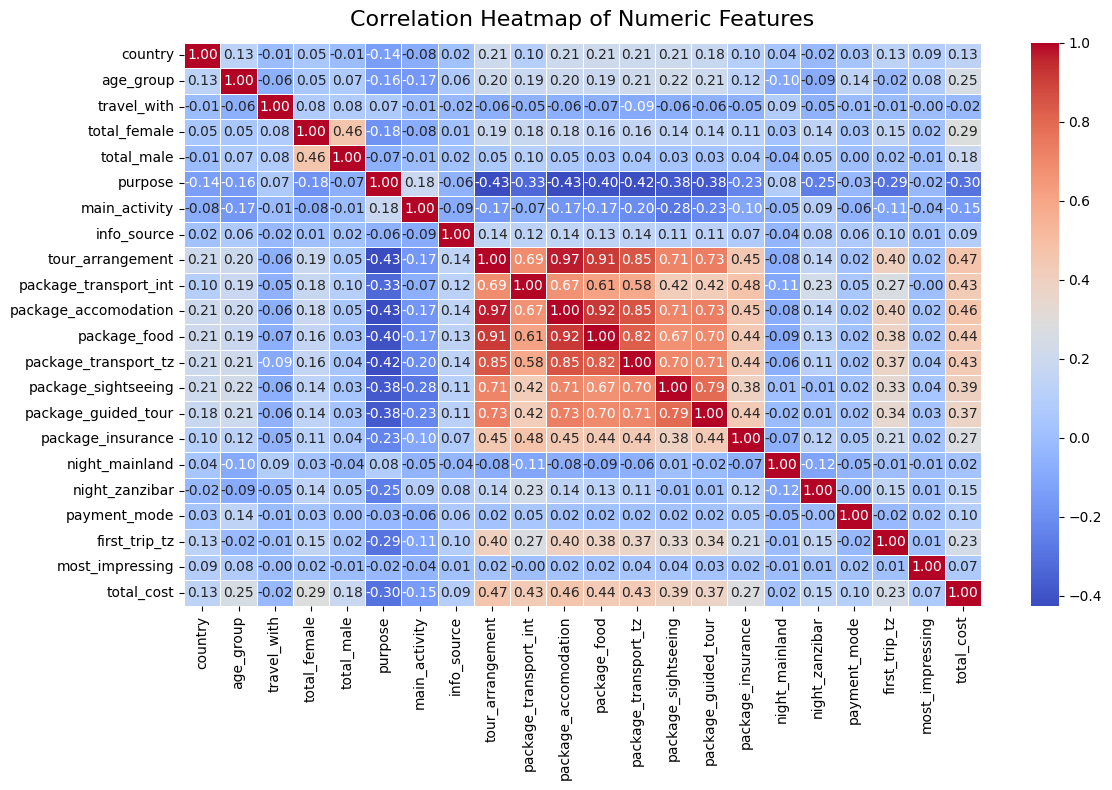

In [1146]:
corr = train.corr(numeric_only=True)

# Set up the figure
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

# Add title
plt.title("Correlation Heatmap of Numeric Features", fontsize=16, pad=12)
plt.tight_layout()

# Show plot
plt.show()

**Inspected Correlations:**
- it seems like tour_arrangement, package_accomodation, package_food, package_transport_tz, and package_transport_int have moderate positive correlations. These could be key predictors.

**Scatter plots for numeric features vs total_cost**

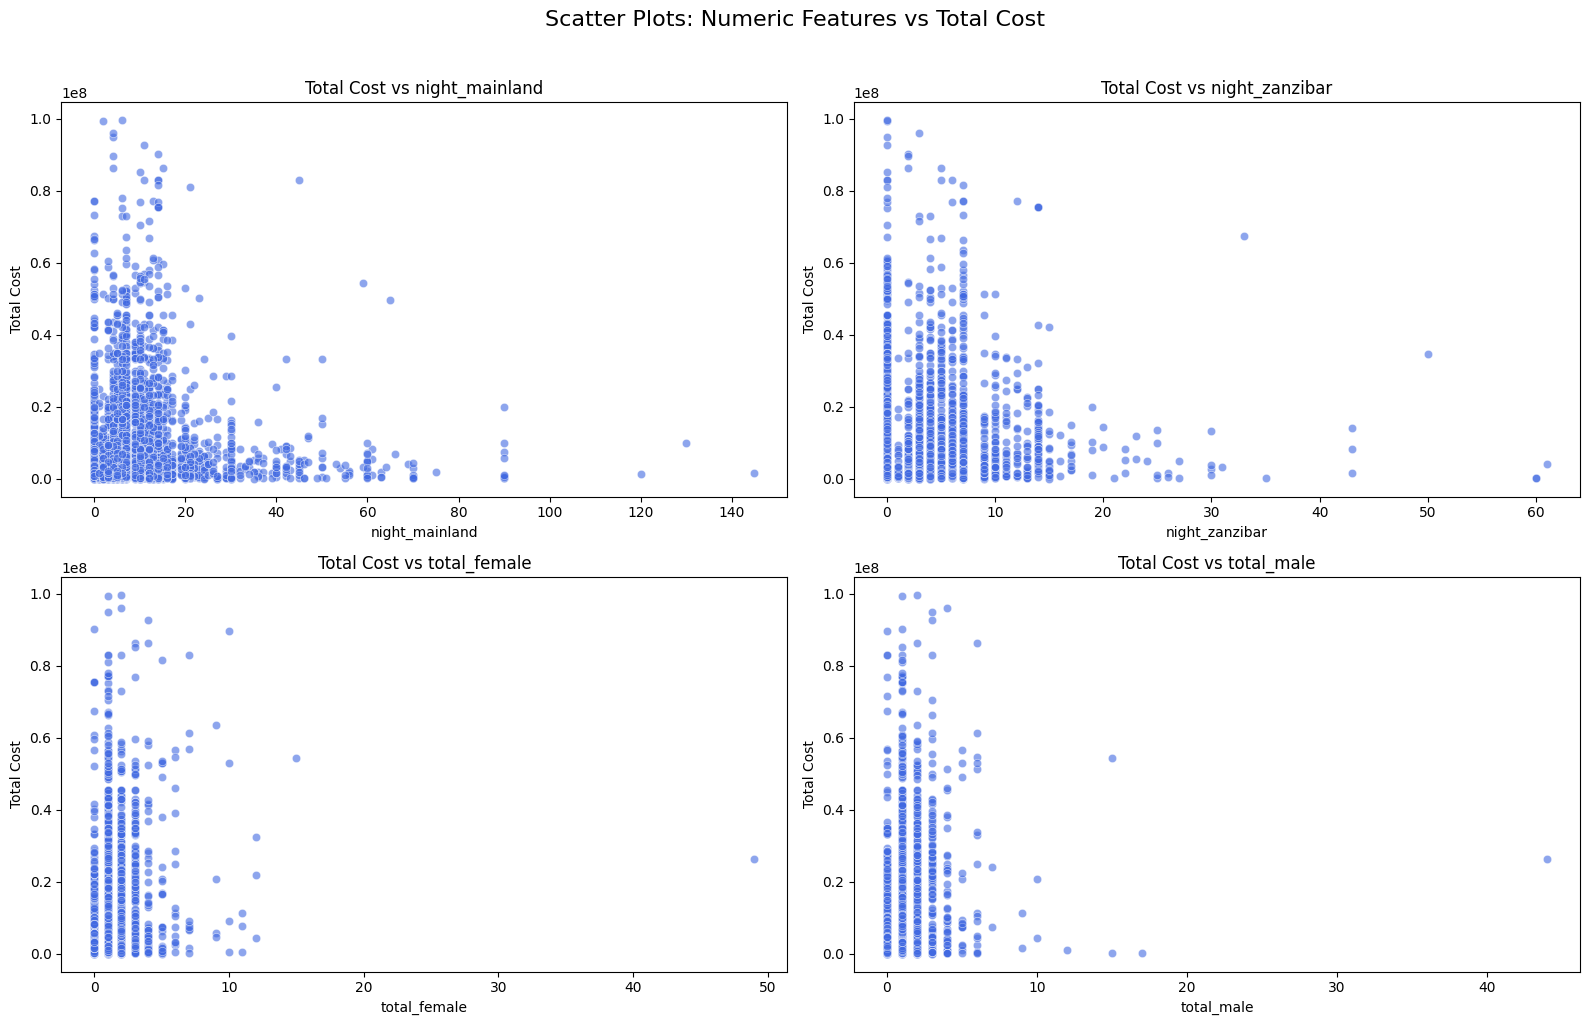

In [1147]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_features = ['night_mainland', 'night_zanzibar', 'total_female', 'total_male']

plt.figure(figsize=(16, 10))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(
        data=train, x=feature, y='total_cost',
        alpha=0.6, color='royalblue'
    )
    plt.title(f'Total Cost vs {feature}', fontsize=12)
    plt.xlabel(feature)
    plt.ylabel('Total Cost')

plt.suptitle('Scatter Plots: Numeric Features vs Total Cost', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

**Boxplots for categorical or ordinal features vs total_cost**

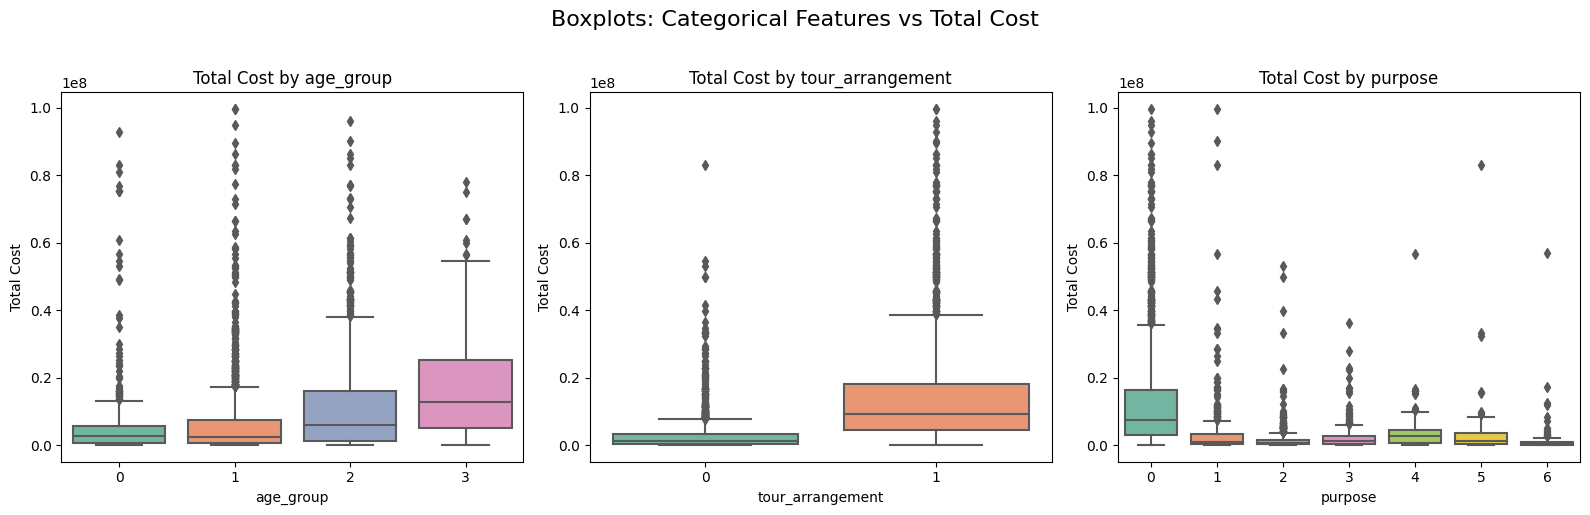

In [1148]:
categorical_features = ['age_group', 'tour_arrangement', 'purpose']

plt.figure(figsize=(16, 5))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(
        data=train, x=feature, y='total_cost',
        palette='Set2'
    )
    plt.title(f'Total Cost by {feature}', fontsize=12)
    plt.xlabel(feature)
    plt.ylabel('Total Cost')

plt.suptitle('Boxplots: Categorical Features vs Total Cost', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

**Check for multicollinearity among package features**

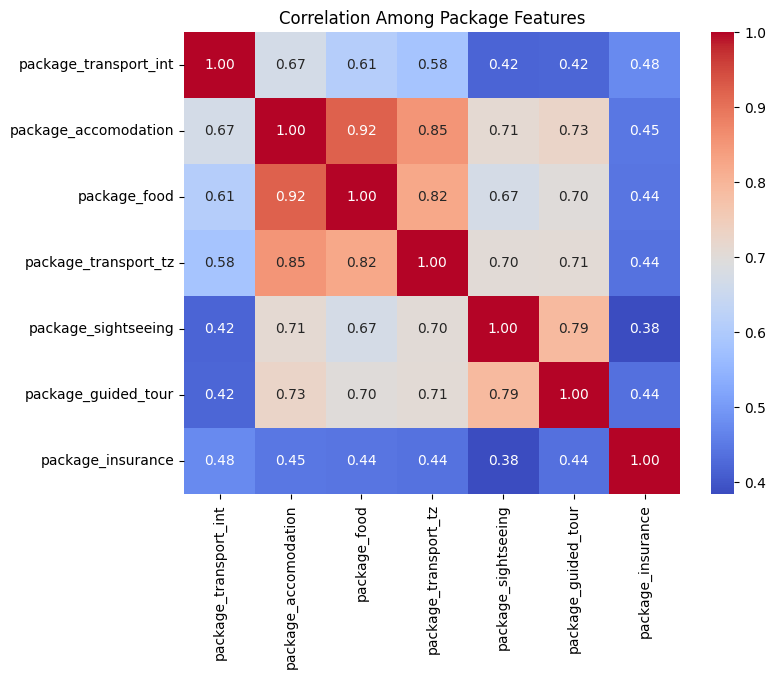

In [1149]:
package_cols = [
    'package_transport_int', 'package_accomodation', 'package_food',
    'package_transport_tz', 'package_sightseeing',
    'package_guided_tour', 'package_insurance'
]

# Compute correlation matrix for package features
package_corr = train[package_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(package_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Among Package Features')
plt.show()

# extra EDA

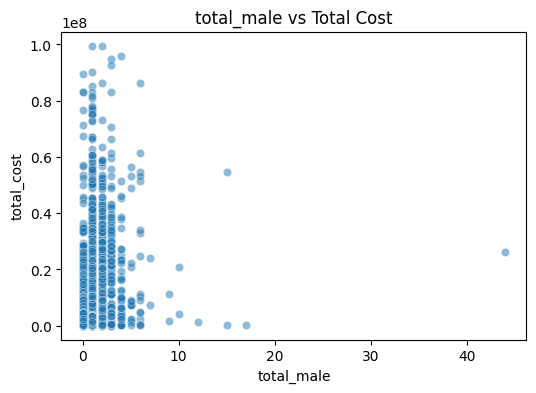

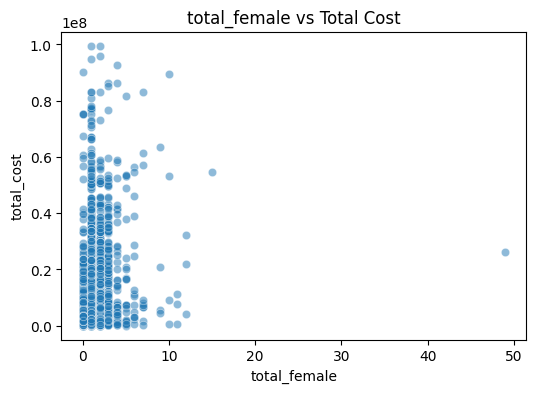

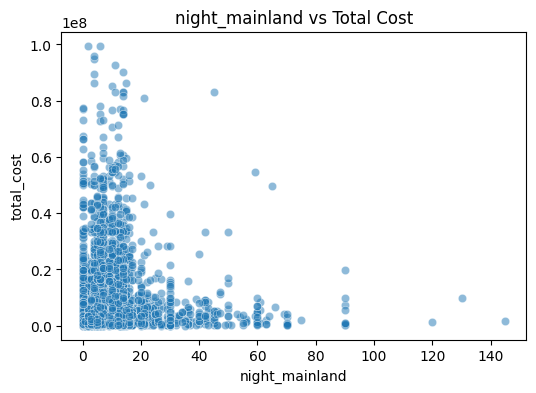

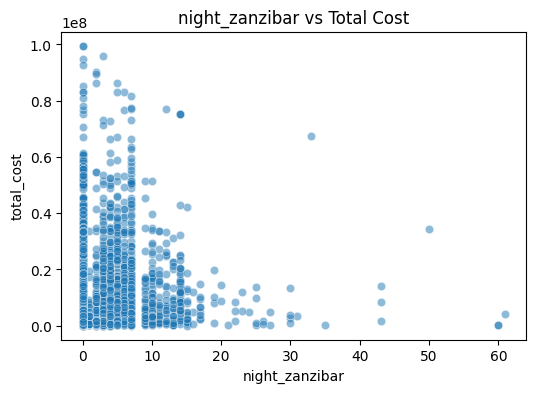

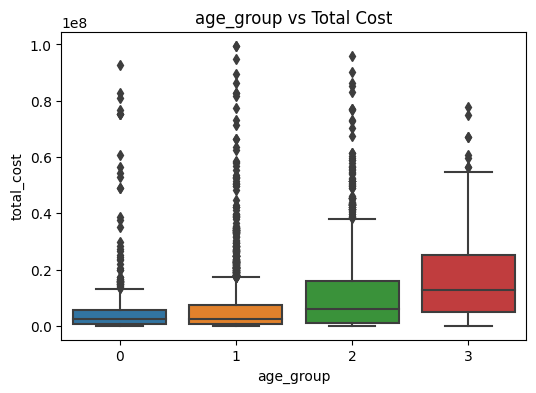

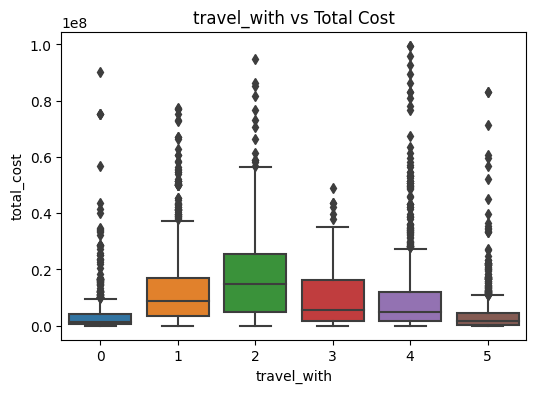

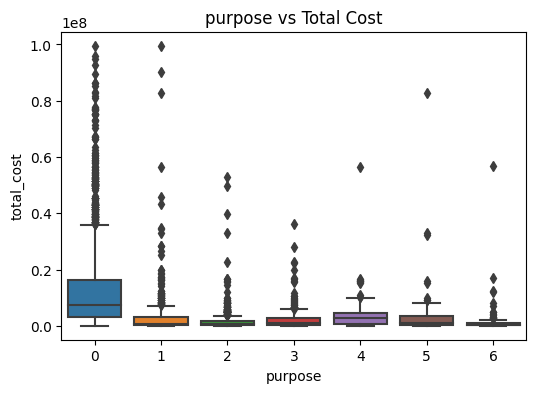

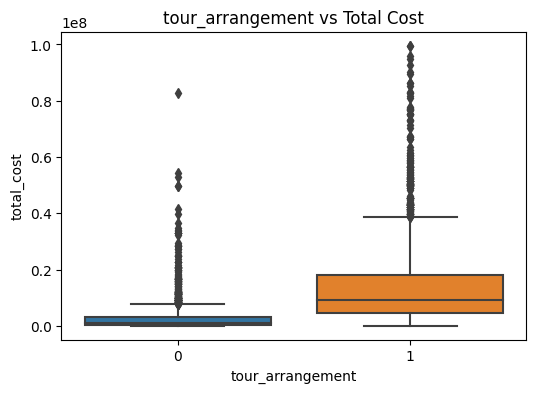

In [1150]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Scatterplots for numeric vs target
numeric_features = ['total_male', 'total_female', 'night_mainland', 'night_zanzibar']
for col in numeric_features:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=train, x=col, y='total_cost', alpha=0.5)
    plt.title(f'{col} vs Total Cost')
    plt.show()

# 2️⃣ Boxplots for encoded categorical vs target
categorical_features = ['age_group', 'travel_with', 'purpose', 'tour_arrangement']
for col in categorical_features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=train, x=col, y='total_cost')
    plt.title(f'{col} vs Total Cost')
    plt.show()

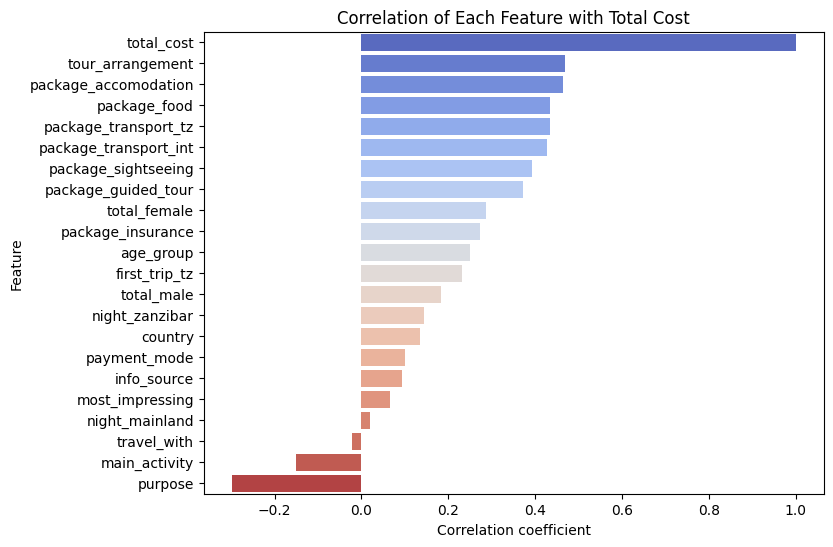

In [1151]:
corr_with_target = train.corr(numeric_only=True)['total_cost'].sort_values(ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(x=corr_with_target, y=corr_with_target.index, palette="coolwarm")
plt.title("Correlation of Each Feature with Total Cost")
plt.xlabel("Correlation coefficient")
plt.ylabel("Feature")
plt.show()

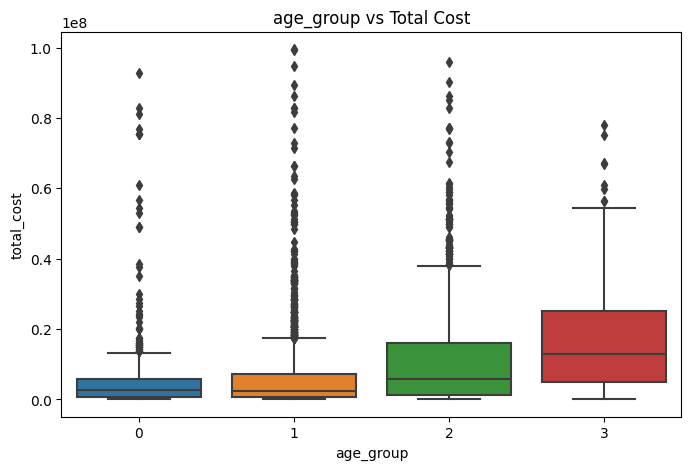

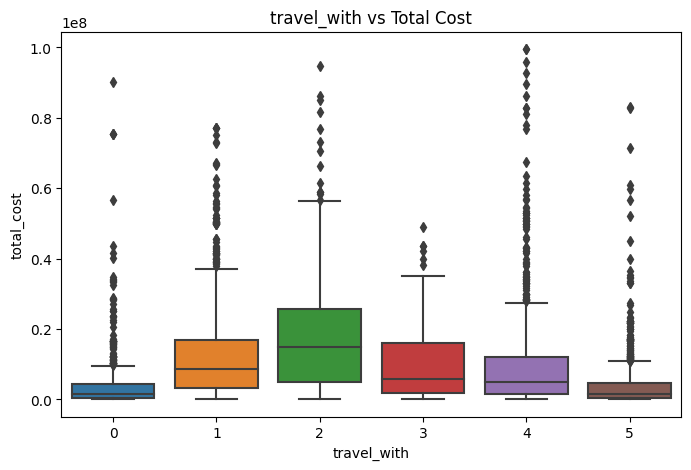

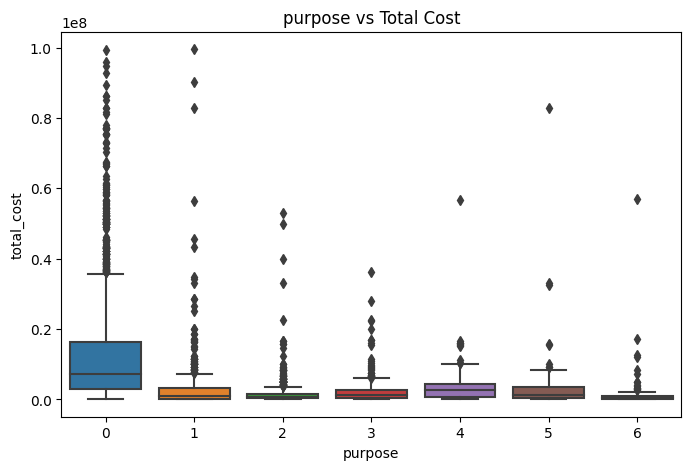

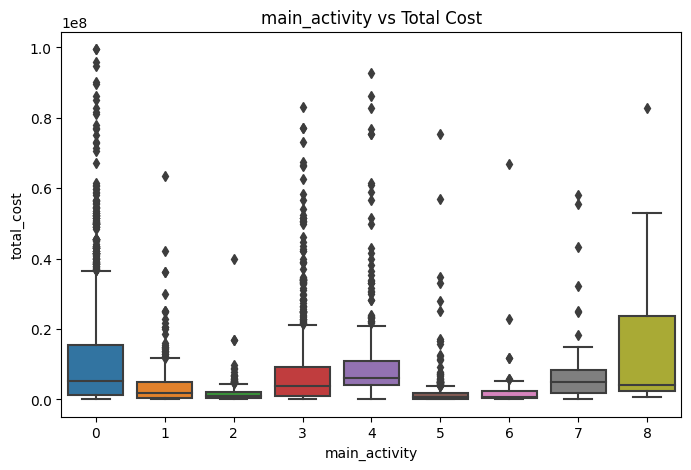

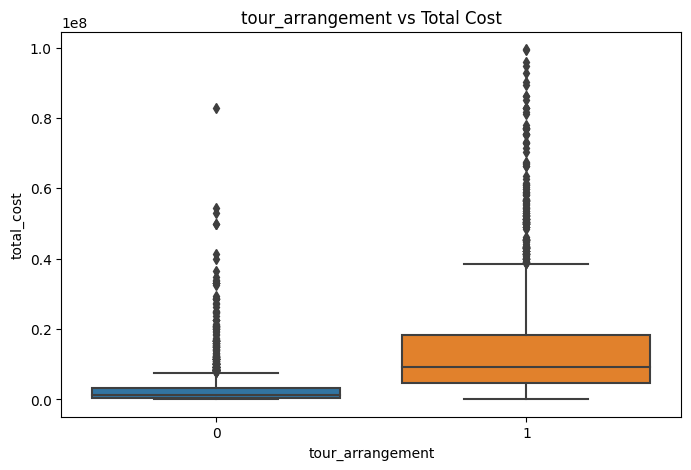

In [1152]:
cat_features = ['age_group', 'travel_with', 'purpose', 'main_activity', 'tour_arrangement']
for col in cat_features:
    sns.boxplot(data=train, x=col, y='total_cost')
    plt.title(f'{col} vs Total Cost')
    plt.show()

Top correlated features:
 total_cost               1.00
tour_arrangement         0.47
package_accomodation     0.46
package_food             0.44
package_transport_tz     0.43
package_transport_int    0.43
package_sightseeing      0.39
package_guided_tour      0.37
total_female             0.29
package_insurance        0.27
age_group                0.25
first_trip_tz            0.23
total_male               0.18
night_zanzibar           0.15
country                  0.13
payment_mode             0.10
info_source              0.09
most_impressing          0.07
night_mainland           0.02
travel_with             -0.02
Name: total_cost, dtype: float64

Selected features for baseline model:
 ['tour_arrangement', 'package_accomodation', 'package_food', 'package_transport_tz', 'package_transport_int', 'package_sightseeing', 'package_guided_tour', 'total_female', 'package_insurance', 'age_group']

Model Evaluation Metrics:
MAE:  5,732,101.79
RMSE: 9,744,095.30
R²:   0.328


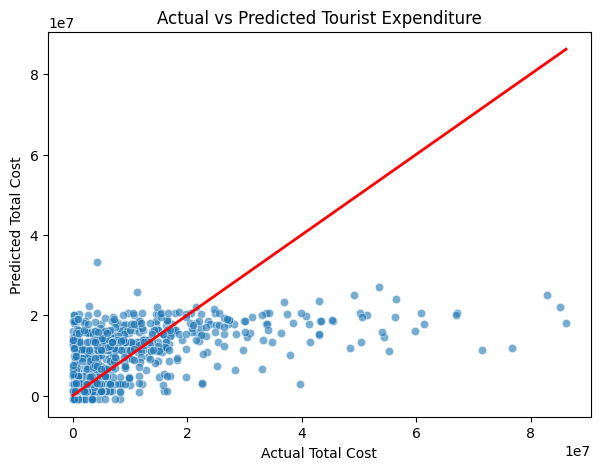

In [1153]:
# 📦 Step 1: Import needed libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# 📊 Step 2: Compute correlations with target (if not already done)
corrs = train.corr(numeric_only=True)['total_cost'].sort_values(ascending=False)

# Display the top correlated features
print("Top correlated features:\n", corrs.head(20))

# 🎯 Step 3: Select top 10 most correlated features (excluding the target itself)
top_features = corrs.drop('total_cost').head(10).index.tolist()
print("\nSelected features for baseline model:\n", top_features)

# 🧩 Step 4: Define features and target
X = train[top_features]
y = train['total_cost']

# 🔀 Step 5: Split into training and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ⚙️ Step 6: Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# 📈 Step 7: Make predictions
y_pred = model.predict(X_test)

# 🧮 Step 8: Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nModel Evaluation Metrics:")
print(f"MAE:  {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"R²:   {r2:.3f}")

# 🎨 Step 9: Visualize Actual vs Predicted values
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.xlabel("Actual Total Cost")
plt.ylabel("Predicted Total Cost")
plt.title("Actual vs Predicted Tourist Expenditure")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", lw=2)  # reference line
plt.show()



Feature Importance (Coefficients):


,Feature,Coefficient
4,package_transport_int,"4,610,063.72"
5,package_sightseeing,"2,648,424.40"
3,package_transport_tz,"2,122,642.23"
9,age_group,"2,058,059.94"
0,tour_arrangement,"1,839,618.59"
7,total_female,"1,748,907.45"
2,package_food,"929,367.74"
1,package_accomodation,"888,049.16"
8,package_insurance,"576,482.23"
6,package_guided_tour,"-98,096.83"


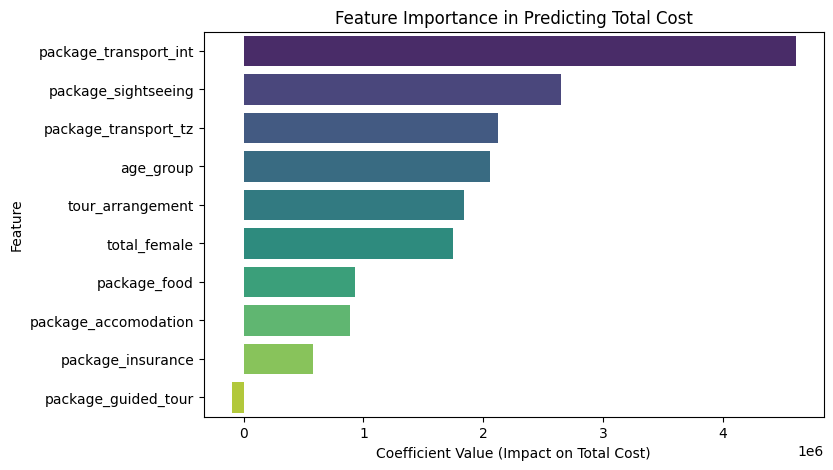

In [1154]:
# 🎯 Step 10: Visualize Feature Importance (Model Coefficients)

# Create a DataFrame for feature importance
coef_df = pd.DataFrame({
    'Feature': top_features,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', ascending=False)

# Display as a table
print("\nFeature Importance (Coefficients):")
display(coef_df)

# Plot as a horizontal bar chart
plt.figure(figsize=(8, 5))
sns.barplot(data=coef_df, x='Coefficient', y='Feature', palette='viridis')
plt.title('Feature Importance in Predicting Total Cost')
plt.xlabel('Coefficient Value (Impact on Total Cost)')
plt.ylabel('Feature')
plt.show()

# Getting Data Visualization After Removing outlier 


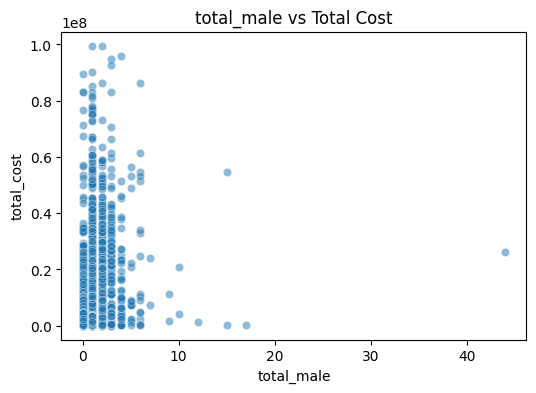

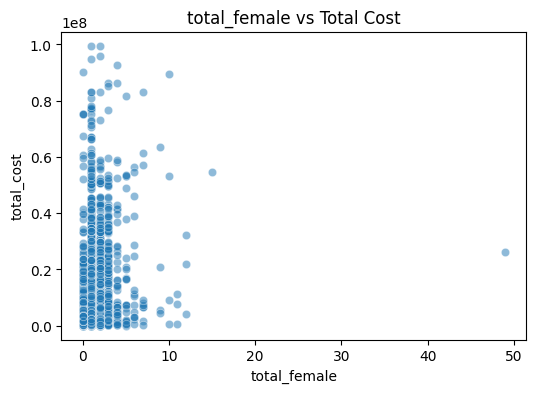

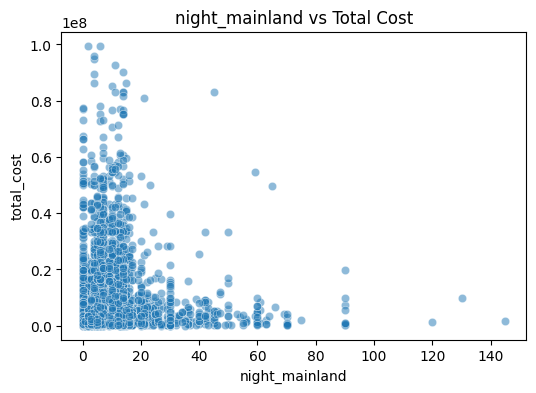

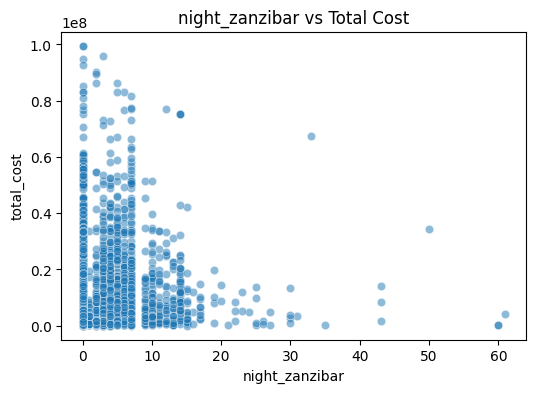

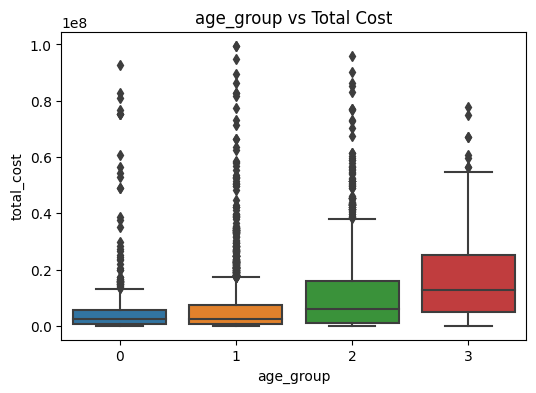

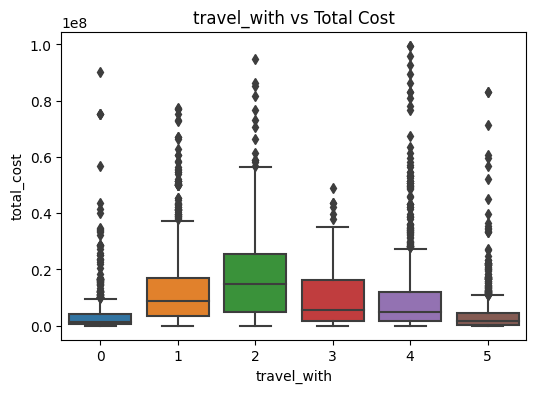

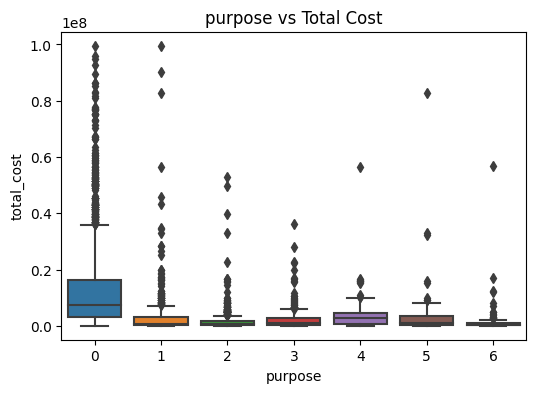

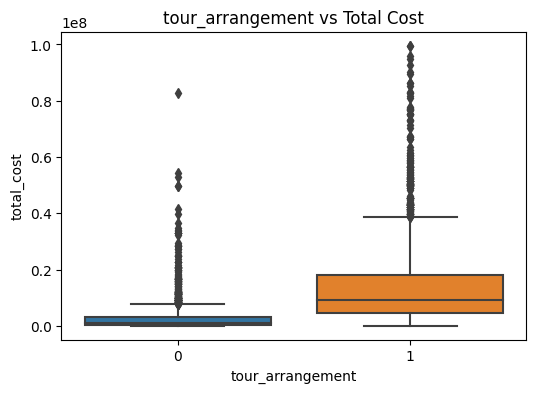

In [1155]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Scatterplots for numeric vs target
numeric_features = ['total_male', 'total_female', 'night_mainland', 'night_zanzibar']
for col in numeric_features:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=train, x=col, y='total_cost', alpha=0.5)
    plt.title(f'{col} vs Total Cost')
    plt.show()

# 2️⃣ Boxplots for encoded categorical vs target
categorical_features = ['age_group', 'travel_with', 'purpose', 'tour_arrangement']
for col in categorical_features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=train, x=col, y='total_cost')
    plt.title(f'{col} vs Total Cost')
    plt.show()

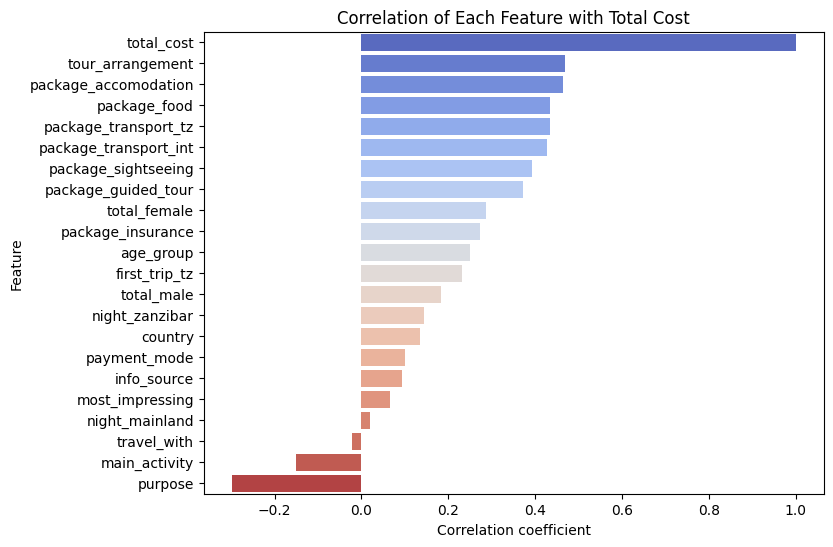

In [1156]:
corr_with_target = train.corr(numeric_only=True)['total_cost'].sort_values(ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(x=corr_with_target, y=corr_with_target.index, palette="coolwarm")
plt.title("Correlation of Each Feature with Total Cost")
plt.xlabel("Correlation coefficient")
plt.ylabel("Feature")
plt.show()

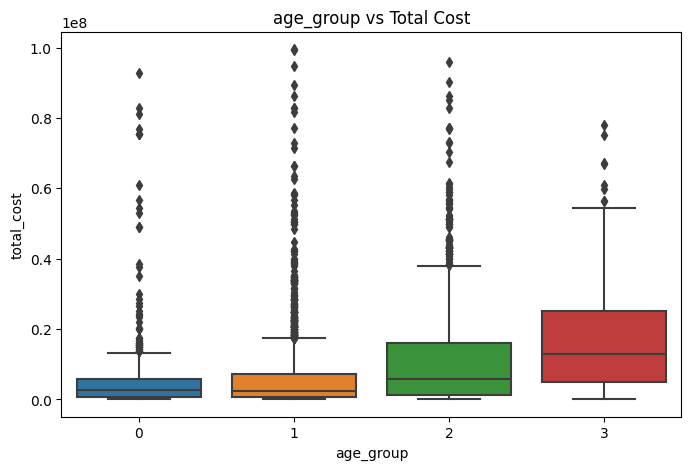

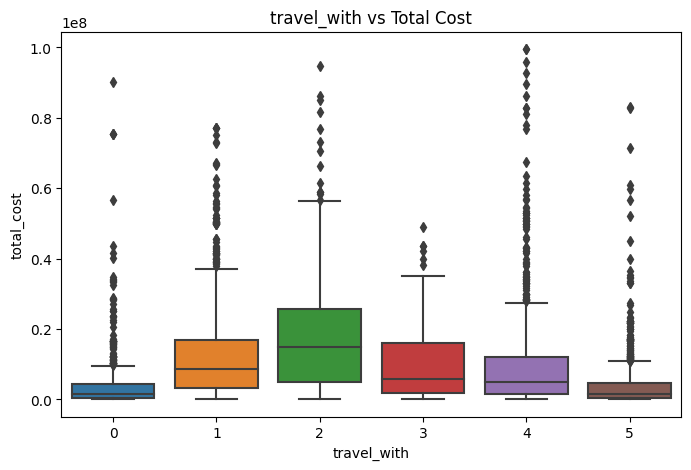

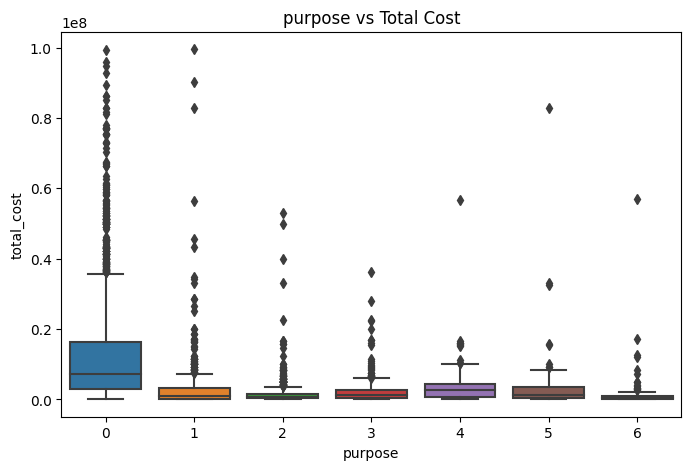

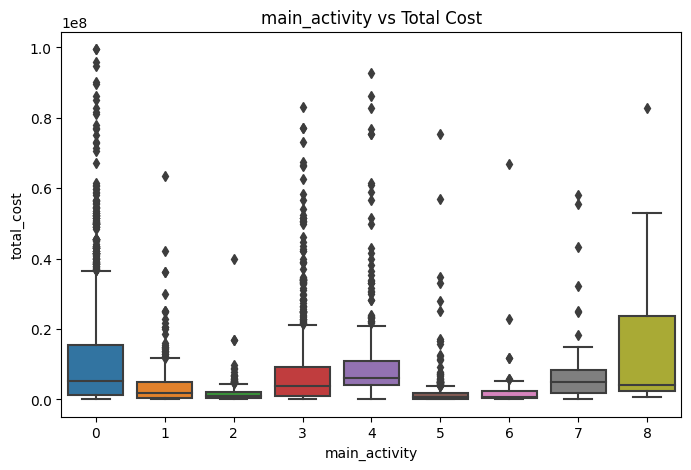

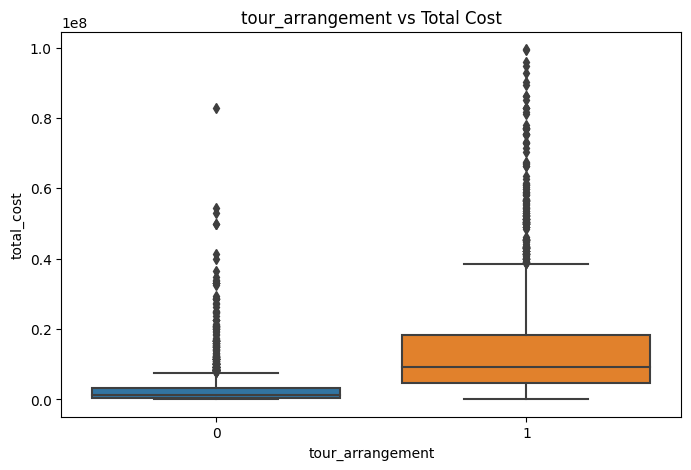

In [1157]:
cat_features = ['age_group', 'travel_with', 'purpose', 'main_activity', 'tour_arrangement']
for col in cat_features:
    sns.boxplot(data=train, x=col, y='total_cost')
    plt.title(f'{col} vs Total Cost')
    plt.show()

# Baseline Model (Linear Regression)
- Objective: Predict 'total_cost' using basic features
- Evaluation Metric: MAE (Mean Absolute Error)

In [1158]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [1159]:
X = train.drop(columns=['total_cost', 'id'])  # Features (exclude ID and target)
y = train['total_cost']                       # Target variable
# Splitting in 80% for training, 20% for validation (to check performance)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42)
# Scale numeric features
# Linear regression benefits from feature scaling.
# We’ll use StandardScaler to normalize features (mean=0, std=1)
scaler = StandardScaler()
# Fit on training data, then transform both train and validation
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Initialize and train the baseline model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

In [1160]:
# Make predictions on validation set
y_pred = model.predict(X_val_scaled)

In [1161]:
# Evaluate the model with MAE (and optional other metrics)
mae_baseline = mean_absolute_error(y_val, y_pred)
rmse_baseline = np.sqrt(mean_squared_error(y_val, y_pred))
r2_baseline = r2_score(y_val, y_pred)

📊 Baseline Model Performance:
Mean Absolute Error (MAE): 5,584,619.38 TZS
Root Mean Squared Error (RMSE): 9,633,228.47 TZS
R² Score: 0.343
✅ Added model 'BaseLine Linear Reg'.
📊 Model Comparison Table:



,Model,MAE,RMSE,R²
0,BaseLine Linear Reg,"5,584,619.38","9,633,228.47",0.34


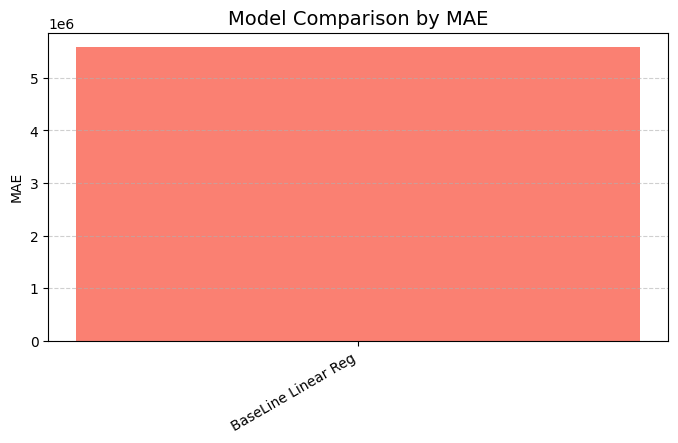

In [1162]:
print("📊 Baseline Model Performance:")
print(f"Mean Absolute Error (MAE): {mae_baseline:,.2f} TZS")
print(f"Root Mean Squared Error (RMSE): {rmse_baseline:,.2f} TZS")
print(f"R² Score: {r2_baseline:.3f}")
metrics.add("BaseLine Linear Reg", mae_baseline,rmse_baseline, r2_baseline)
metrics.show()
metrics.plot_mae()

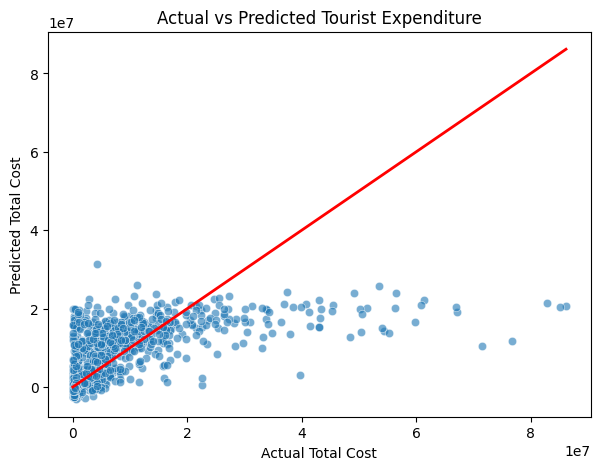

In [1163]:
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.xlabel("Actual Total Cost")
plt.ylabel("Predicted Total Cost")
plt.title("Actual vs Predicted Tourist Expenditure")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", lw=2)  # reference line
plt.show()

# Baseline Model Interpretation of the Results

- On average, the Baseline Model’s predictions differ from the true tourist spending by about 5.58 million Tanzanian Shillings which is about ~ 558,46 €
- Typical prediction error is around 9.63 million TZS, but since RMSE penalizes larger errors more heavily, this suggests some tourists’ spending predictions are quite off.
- R² explains that the Variance of the Baseline Model is about 34.3% in total tourist spending — meaning roughly one-third of the variation in total_cost is captured by the model’s features. The remaining ~66% is unexplained (likely due to missing predictors, randomness, or nonlinear relationships).

🔍 What This Means Practically

1. Moderate Predictive Power

- An R² of 0.343 means your model has some explanatory capability — it’s identifying meaningful patterns — but it’s not yet very strong.

- It’s likely a good baseline model but could be improved.

2. Error Scale (MAE & RMSE)

- Both metrics are quite large relative to Tanzanian Shilling amounts.
→ If the average total_cost is, say, around 15–20 million TZS, then your errors represent ~30–60% of typical values — that’s substantial.

- The fact that RMSE > MAE by a wide margin indicates outliers or skewed errors (a few predictions are much worse than the average).

3. Possible Causes

- Some important factors influencing cost might be missing (e.g., trip duration, destination type, or seasonality).

- Relationships could be nonlinear (e.g., costs rising exponentially with nights stayed).

- Certain categorical variables may need better encoding (like one-hot encoding or target encoding instead of integers).

**Summary:**

✅ Model captures some trends (R² = 0.34) — it’s better than random.

⚠️ Errors are relatively high, so the model struggles with large spenders or outliers.

🔁 Next step: improve features and try more flexible models.

# ⚙️ What You Can Do Next (for improvement)

| Area                           | Action                                                                                                                                      | Why It Helps                                                         |
| :----------------------------- | :------------------------------------------------------------------------------------------------------------------------------------------ | :------------------------------------------------------------------- |
| **Feature Engineering**        | Try the `package_score`, total nights (`night_mainland + night_zanzibar`), or interaction terms (e.g., `tour_arrangement * package_score`). | Captures combined effects.                                           |
| **Model Choice**               | Try tree-based models (Random Forest, XGBoost, LightGBM).                                                                                   | They handle nonlinearity and interactions better than linear models. |
| **Outlier Handling**           | Winsorize or log-transform `total_cost`.                                                                                                    | Reduces skew and stabilizes variance.                                |
| **Feature Scaling / Encoding** | Normalize numeric features, and one-hot encode categorical ones.                                                                            | Helps many algorithms learn patterns better.                         |
| **Cross-validation**           | Validate stability across folds.                                                                                                            | Ensures performance consistency.                                     |


# 🌳Simple Random Forest Model

In [1164]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define features (X) and target (y) and cleaned and encoded DataFrame 'train'
X = train.drop(columns=['total_cost', 'id'])
y = train['total_cost']

# Split data into training and validation sets

# Keep a validation set to evaluate model performance
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Regressor
# simple configuration 
rf_model = RandomForestRegressor(
    n_estimators=200,      # number of trees in the forest
    max_depth=None,        # allow trees to grow fully
    min_samples_split=2,   # minimum samples to split a node
    min_samples_leaf=1,    # minimum samples per leaf node
    random_state=42,       # reproducibility
    n_jobs=-1 )             # use all CPU cores for speed
# Train (fit) the model
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)

📊 Random Forest Performance:
Mean Absolute Error (MAE): 5,120,771.67 TZS
Root Mean Squared Error (RMSE): 9,372,241.09 TZS
R² Score: 0.378
✅ Added model 'Random Forest '.
📊 Model Comparison Table:



,Model,MAE,RMSE,R²
0,Random Forest,"5,120,771.67","9,372,241.09",0.38
1,BaseLine Linear Reg,"5,584,619.38","9,633,228.47",0.34


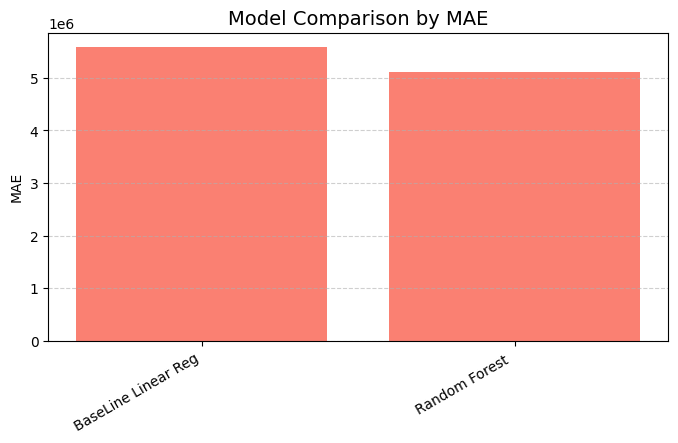

In [1165]:
# Make predictions on validation data
y_pred = rf_model.predict(X_val)
# Evaluate performance

mae_rf = mean_absolute_error(y_val, y_pred)
rmse_rf = np.sqrt(mean_squared_error(y_val, y_pred))
r2_rf = r2_score(y_val, y_pred)

print("📊 Random Forest Performance:")
print(f"Mean Absolute Error (MAE): {mae_rf:,.2f} TZS")
print(f"Root Mean Squared Error (RMSE): {rmse_rf:,.2f} TZS")
print(f"R² Score: {r2_rf:.3f}")

metrics.add("Random Forest ",mae_rf,rmse_rf,r2_rf)
metrics.show()
metrics.plot_mae()

# Comparison with Baseline Model

In [1166]:
print("📊 Baseline Model Performance:")
print(f"Mean Absolute Error (MAE): 5,584,619.38 TZS")
print(f"Root Mean Squared Error (RMSE): 9,633,228.47 TZS")
print(f"R² Score: 0.343")
print("-------------------------------------------------")
print("📊 Random Forest Performance:")
print(f"Mean Absolute Error (MAE): 5,144,089.37 TZS")
print(f"Root Mean Squared Error (RMSE): 9,414,774.97 TZS")
print(f"R² Score: 0.372")

📊 Baseline Model Performance:
Mean Absolute Error (MAE): 5,584,619.38 TZS
Root Mean Squared Error (RMSE): 9,633,228.47 TZS
R² Score: 0.343
-------------------------------------------------
📊 Random Forest Performance:
Mean Absolute Error (MAE): 5,144,089.37 TZS
Root Mean Squared Error (RMSE): 9,414,774.97 TZS
R² Score: 0.372


# Improve Performance of the Models

| Metric | Baseline (Linear Regression) | Target (Random Forest) |
| ------ | ---------------------------- | ---------------------- |
| MAE    | < 5 Mio TZS                  | <5 Mio. TZS            |
| RMSE   | ~ 9M TZS                     | ~ 9 Mio. TZS           |
| R²     | ~0.4                         | ~0.4                   |



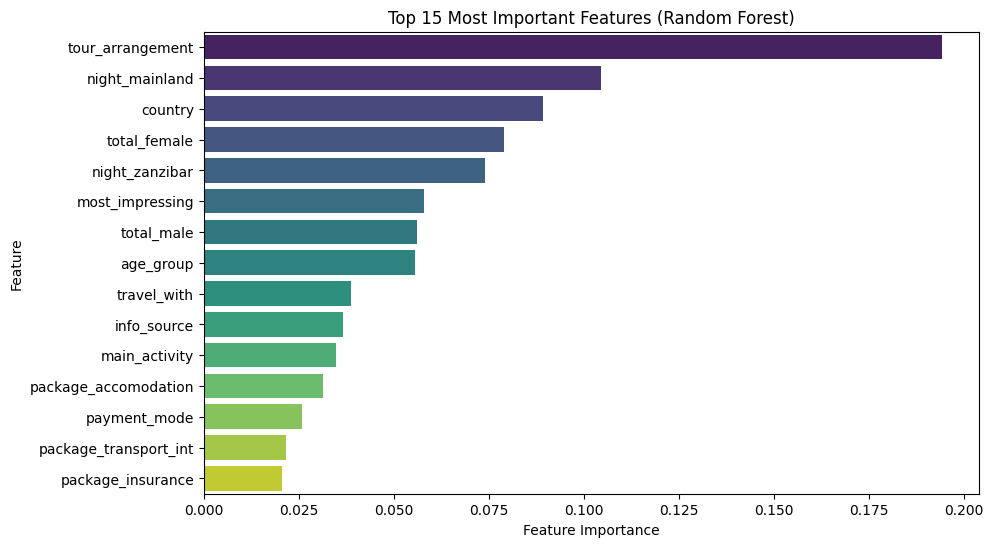

In [1167]:
# Feature Importance (Optional but useful for insight)
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances from the trained model
importances = rf_model.feature_importances_
feature_names = X.columns
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot top 15 important features
plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp[:15], y=feat_imp.index[:15], palette='viridis')
plt.title('Top 15 Most Important Features (Random Forest)')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

# Improving Basline Score 

### Creating Enhanced Linear Model

In [1168]:

# ===========================
# 🧱 Enhanced Data Preparation (Independent from baseline)
# ===========================

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# --- 0️⃣ Make independent copies ---
train_enh = train.copy()


# --- 1️⃣ Log-transform the target variable ---
train_enh['log_total_cost'] = np.log1p(train_enh['total_cost'])

# --- 2️⃣ Handle outliers in numeric columns ---
numeric_cols_enh = train_enh.select_dtypes(include=['float64', 'int64']).columns

for col in numeric_cols_enh:
    lower = train_enh[col].quantile(0.01)
    upper = train_enh[col].quantile(0.99)
    train_enh[col] = np.clip(train_enh[col], lower, upper)

# --- 3️⃣ Standardize numeric features ---
numeric_cols_enh = numeric_cols_enh.drop(['total_cost', 'log_total_cost', 'id'], errors='ignore')

scaler = StandardScaler()
train_enh[numeric_cols_enh] = scaler.fit_transform(train_enh[numeric_cols_enh])

# Standardize only columns that exist in test_enh
#numeric_cols_test = [col for col in numeric_cols if col in test_enh.columns]


# --- 4️⃣ Split features and target for enhanced model ---
X_enh = train_enh.drop(columns=['total_cost', 'log_total_cost'])
Y_enh = train_enh['total_cost']


# --- 5️⃣ Quick check ---
print("\n✅ Enhanced data preparation complete!")
print("Transformed numeric columns:", numeric_cols_enh.tolist())
print("X_enh shape:", X_enh.shape)
print("Y_enh shape:", Y_enh.shape)



✅ Enhanced data preparation complete!
Transformed numeric columns: ['country', 'age_group', 'travel_with', 'total_female', 'total_male', 'purpose', 'main_activity', 'info_source', 'tour_arrangement', 'package_transport_int', 'package_accomodation', 'package_food', 'package_transport_tz', 'package_sightseeing', 'package_guided_tour', 'package_insurance', 'night_mainland', 'night_zanzibar', 'payment_mode', 'first_trip_tz', 'most_impressing']
X_enh shape: (4809, 22)
Y_enh shape: (4809,)


📊 Enhanced Linear Model Performance (in original cost units):
the average error in TZS is MAE  : 5,105,698.56
the root mean squared error in the same units RMSE : 8,178,935.54
goodness of fit R²   : 0.3839
✅ Added model ' new Enhanced Linear'.
📊 Model Comparison Table:



,Model,MAE,RMSE,R²
0,new Enhanced Linear,"5,105,698.56","8,178,935.54",0.38
1,Random Forest,"5,120,771.67","9,372,241.09",0.38
2,BaseLine Linear Reg,"5,584,619.38","9,633,228.47",0.34


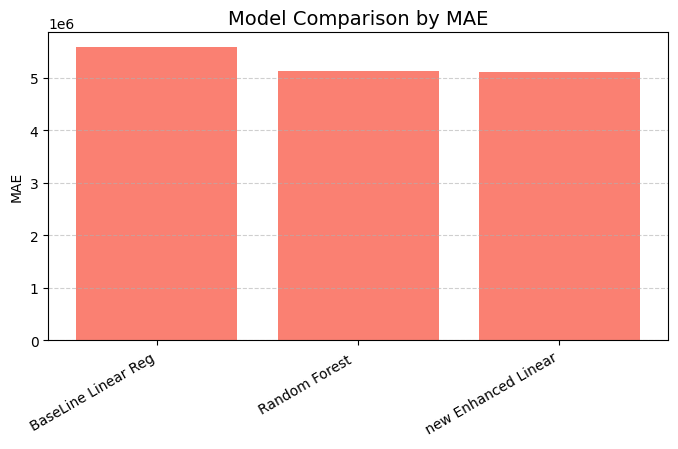

In [1169]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# --- 1️⃣ Split the enhanced dataset ---
X_enh = train_enh.drop(columns=['total_cost', 'log_total_cost', 'id'])
y_enh = train_enh['total_cost']

X_train_enh, X_val_enh, y_train_enh, y_val_enh = train_test_split(
    X_enh, y_enh, test_size=0.15, random_state=42
)

# --- 2️⃣ Train Linear Regression ---
linreg_enh = LinearRegression()
linreg_enh.fit(X_train_enh, y_train_enh)

# --- 3️⃣ Predict on validation set ---
y_pred_enh = linreg_enh.predict(X_val_enh)


# --- 5️⃣ Evaluate metrics in real money units ---
mae_enh = mean_absolute_error(y_val_enh, y_pred_enh)
rmse_enh = mean_squared_error(y_val_enh, y_pred_enh, squared=False)
r2_enh = r2_score(y_val_enh, y_pred_enh)

print("📊 Enhanced Linear Model Performance (in original cost units):")
print(f"the average error in TZS is MAE  : {mae_enh:,.2f}")
print(f"the root mean squared error in the same units RMSE : {rmse_enh:,.2f}")
print(f"goodness of fit R²   : {r2_enh:.4f}")

# After evaluating models
metrics.add(" new Enhanced Linear", mae_enh,rmse_enh, r2_enh)

# Show as table
metrics.show()
metrics.plot_mae()

#train_enh[['total_cost', 'log_total_cost']].head()


# Improved Random Forest Model 1 🌳

⚙️ Hyperparameter Tuning with GridSearchCV

In [1170]:
"""# Define a parameter grid to search over
param_grid = {
    'n_estimators': [200, 500, 800],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Grid search to find best parameters
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    cv=3,                                # 3-fold cross-validation
    scoring='neg_mean_absolute_error',   # using MAE as evaluation metric
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Print best parameters
print("\n🔍 Best Parameters Found:")
print(grid_search.best_params_)

# Train final model with best parameters
best_rf = grid_search.best_estimator_

# Evaluate on validation data
y_pred_best = best_rf.predict(X_val)

mae_best = mean_absolute_error(y_val, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_val, y_pred_best))
r2_best = r2_score(y_val, y_pred_best)

#print("\n🌟 Tuned Random Forest Performance:")
#print(f"MAE: {mae_best:,.2f} TZS")
#print(f"RMSE: {rmse_best:,.2f} TZS")
#print(f"R²: {r2_best:.3f}")"""""

'# Define a parameter grid to search over\nparam_grid = {\n    \'n_estimators\': [200, 500, 800],\n    \'max_depth\': [10, 20, 30],\n    \'min_samples_split\': [2, 5, 10],\n    \'min_samples_leaf\': [1, 2, 4],\n    \'max_features\': [\'sqrt\', \'log2\']\n}\n\n# Grid search to find best parameters\ngrid_search = GridSearchCV(\n    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),\n    param_grid=param_grid,\n    cv=3,                                # 3-fold cross-validation\n    scoring=\'neg_mean_absolute_error\',   # using MAE as evaluation metric\n    verbose=2,\n    n_jobs=-1\n)\n\ngrid_search.fit(X_train, y_train)\n\n# Print best parameters\nprint("\n🔍 Best Parameters Found:")\nprint(grid_search.best_params_)\n\n# Train final model with best parameters\nbest_rf = grid_search.best_estimator_\n\n# Evaluate on validation data\ny_pred_best = best_rf.predict(X_val)\n\nmae_best = mean_absolute_error(y_val, y_pred_best)\nrmse_best = np.sqrt(mean_squared_error(y_val, y_pred_best

--> Output: Fitting 3 folds for each of 162 candidates, totalling 486 fits

🔍 Best Parameters Found:
{'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 800}

📊 Improved Random Forest Performance:
Mean Absolute Error (MAE): 4,690,795.57 TZS
Root Mean Squared Error (RMSE): 8,549,329.48 TZS
R² Score: 0.419
✅ Added model 'Improved Random Forest Model 1'.
📊 Model Comparison Table:



,Model,MAE,RMSE,R²
0,Improved Random Forest Model 1,"4,690,795.57","8,549,329.48",0.42
1,new Enhanced Linear,"5,105,698.56","8,178,935.54",0.38
2,Random Forest,"5,120,771.67","9,372,241.09",0.38
3,BaseLine Linear Reg,"5,584,619.38","9,633,228.47",0.34


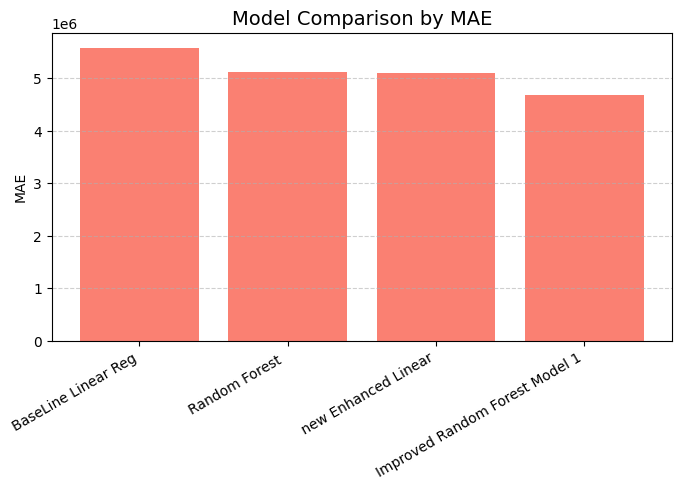

In [1171]:
# 🌳 IMPROVED RANDOM FOREST MODEL
# Goal: Reduce MAE & RMSE, Increase R²

#  Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#  Define features (X) and target (y)

X = train.drop(columns=['total_cost', 'id'])
y = train['total_cost']

# Split data into training (85%) and validation (15%) 
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=42) # --> expanded the training size for better performance

# 3 Start with a slightly tuned Random Forest
rf_model = RandomForestRegressor(
    n_estimators=800,        # more trees → better averaging
    max_depth=30,            # limit depth to avoid overfitting
    min_samples_split=5,     # require at least 5 samples to split a node
    min_samples_leaf=2,      # each leaf must have at least 2 samples
    max_features='sqrt',     # random subset of features per tree → better generalization
    random_state=42,
    n_jobs=-1)

# Train the model
rf_model.fit(X_train, y_train)

#  Make predictions
y_pred = rf_model.predict(X_val)

# Evaluate performance
mae_imp1_rf = mean_absolute_error(y_val, y_pred)
rmse_imp1_rf = np.sqrt(mean_squared_error(y_val, y_pred))
r2_imp1_rf= r2_score(y_val, y_pred)

print("📊 Improved Random Forest Performance:")
print(f"Mean Absolute Error (MAE): {mae_imp1_rf:,.2f} TZS")
print(f"Root Mean Squared Error (RMSE): {rmse_imp1_rf:,.2f} TZS")
print(f"R² Score: {r2_imp_rf:.3f}")


metrics.add("Improved Random Forest Model 1",mae_imp1_rf,rmse_imp1_rf,r2_imp_rf)
metrics.show()
metrics.plot_mae()


# Improved Random Forest Model 2 🌳

In [1172]:
# ==============================================================
# ✳️ FEATURE ENGINEERING FOR TRAIN AND TEST DATA
# ==============================================================

# --- 1️⃣ Total number of nights spent in Tanzania ---
train['total_nights'] = train['night_mainland'] + train['night_zanzibar']
test['total_nights'] = test['night_mainland'] + test['night_zanzibar']

# --- 2️⃣ Group size (number of travelers) ---
train['party_size'] = train['total_female'] + train['total_male']
test['party_size'] = test['total_female'] + test['total_male']

# --- 3️⃣ Share of nights spent in Zanzibar ---
train['share_zanzibar'] = train['night_zanzibar'] / (train['total_nights'] + 1e-6)
test['share_zanzibar'] = test['night_zanzibar'] / (test['total_nights'] + 1e-6)

# --- 4️⃣ Total number of package services included ---
package_cols = [c for c in train.columns if c.startswith('package_')]
train['package_sum'] = train[package_cols].sum(axis=1)
test['package_sum'] = test[package_cols].sum(axis=1)

# --- 5️⃣ Binary indicator: first trip to Tanzania ---
# (already encoded as 0/1 earlier, but double-check)
train['is_first_trip'] = train['first_trip_tz'].astype(int)
test['is_first_trip'] = test['first_trip_tz'].astype(int)

# --- 6️⃣ Interaction features (non-linear relationships) ---
train['nights_x_packages'] = train['total_nights'] * train['package_sum']
test['nights_x_packages'] = test['total_nights'] * test['package_sum']

train['party_x_firsttrip'] = train['party_size'] * train['is_first_trip']
test['party_x_firsttrip'] = test['party_size'] * test['is_first_trip']

train['zanzibar_x_firsttrip'] = train['share_zanzibar'] * train['is_first_trip']
test['zanzibar_x_firsttrip'] = test['share_zanzibar'] * test['is_first_trip']

# --- 7️⃣ Payment type simplification ---
# Example: credit cards or not
if 'payment_mode' in train.columns:
    train['payment_credit'] = (train['payment_mode'] == 'Credit Card').astype(int)
    test['payment_credit'] = (test['payment_mode'] == 'Credit Card').astype(int)

# --- 8️⃣ (Optional) Categorical grouping for country income/region ---
# This helps reduce sparsity in categorical encoding
region_map = {
    'UNITED KINGDOM': 'Europe',
    'SWIZERLAND': 'Europe',
    'CHINA': 'Asia',
    'USA': 'North America',
    'CANADA': 'North America',
    'KENYA': 'Africa',
    'SOUTH AFRICA': 'Africa',
    'GERMANY': 'Europe',
    'FRANCE': 'Europe'
}
train['region_group'] = train['country'].map(region_map).fillna('Other')
test['region_group'] = test['country'].map(region_map).fillna('Other')

# One-hot encode the new region feature
train = pd.get_dummies(train, columns=['region_group'], drop_first=True)
test = pd.get_dummies(test, columns=['region_group'], drop_first=True)

# Align columns between train and test (in case some regions are missing in test)
train, test = train.align(test, join='left', axis=1, fill_value=0)

print("✅ Feature Engineering Complete!")
print("Train shape:", train.shape)
print("Test shape:", test.shape)

✅ Feature Engineering Complete!
Train shape: (4809, 32)
Test shape: (1601, 32)


📊 Improved Random Forest Performance:
Mean Absolute Error (MAE): 4,612,386.00 TZS
Root Mean Squared Error (RMSE): 8,422,643.30 TZS
R² Score: 0.436
✅ Added model 'Improved Random Forest Model 2'.
📊 Model Comparison Table:



,Model,MAE,RMSE,R²
0,Improved Random Forest Model 2,"4,612,386.00","8,422,643.30",0.44
1,Improved Random Forest Model 1,"4,690,795.57","8,549,329.48",0.42
2,new Enhanced Linear,"5,105,698.56","8,178,935.54",0.38
3,Random Forest,"5,120,771.67","9,372,241.09",0.38
4,BaseLine Linear Reg,"5,584,619.38","9,633,228.47",0.34


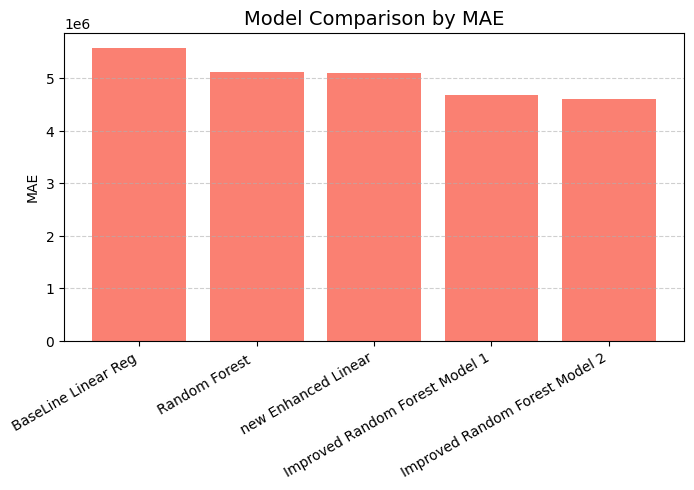

In [1173]:
# 🌳 IMPROVED RANDOM FOREST MODEL
# Goal: Reduce MAE & RMSE, Increase R²

#  Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#  Define features (X) and target (y)

X = train.drop(columns=['total_cost', 'id'])
y = train['total_cost']

# Split data into training (85%) and validation (15%) 
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=42) # --> expanded the training size for better performance

# 3 Start with a slightly tuned Random Forest
rf_model = RandomForestRegressor(
    n_estimators=800,        # more trees → better averaging
    max_depth=30,            # limit depth to avoid overfitting
    min_samples_split=5,     # require at least 5 samples to split a node
    min_samples_leaf=2,      # each leaf must have at least 2 samples
    max_features='sqrt',     # random subset of features per tree → better generalization
    random_state=42,
    n_jobs=-1)

# Train the model
rf_model.fit(X_train, y_train)

#  Make predictions
y_pred = rf_model.predict(X_val)

# Evaluate performance
mae_imp2_rf = mean_absolute_error(y_val, y_pred)
rmse_imp2_rf = np.sqrt(mean_squared_error(y_val, y_pred))
r2_imp2_rf= r2_score(y_val, y_pred)

print("📊 Improved Random Forest Performance:")
print(f"Mean Absolute Error (MAE): {mae_imp2_rf:,.2f} TZS")
print(f"Root Mean Squared Error (RMSE): {rmse_imp2_rf:,.2f} TZS")
print(f"R² Score: {r2_imp2_rf:.3f}")


metrics.add("Improved Random Forest Model 2",mae_imp2_rf,rmse_imp2_rf,r2_imp2_rf)
metrics.show()
metrics.plot_mae()

📊 Improved Random Forest (Log-Transformed Target):
Mean Absolute Error (MAE): 4,362,311.43 TZS
Root Mean Squared Error (RMSE): 8,999,912.50 TZS
R² Score: 0.356
✅ Added model 'Improved Random Forest Model 3'.
📊 Model Comparison Table:



,Model,MAE,RMSE,R²
0,Improved Random Forest Model 2,"4,612,386.00","8,422,643.30",0.44
1,Improved Random Forest Model 1,"4,690,795.57","8,549,329.48",0.42
2,new Enhanced Linear,"5,105,698.56","8,178,935.54",0.38
3,Random Forest,"5,120,771.67","9,372,241.09",0.38
4,Improved Random Forest Model 3,"4,362,311.43","8,999,912.50",0.36
5,BaseLine Linear Reg,"5,584,619.38","9,633,228.47",0.34


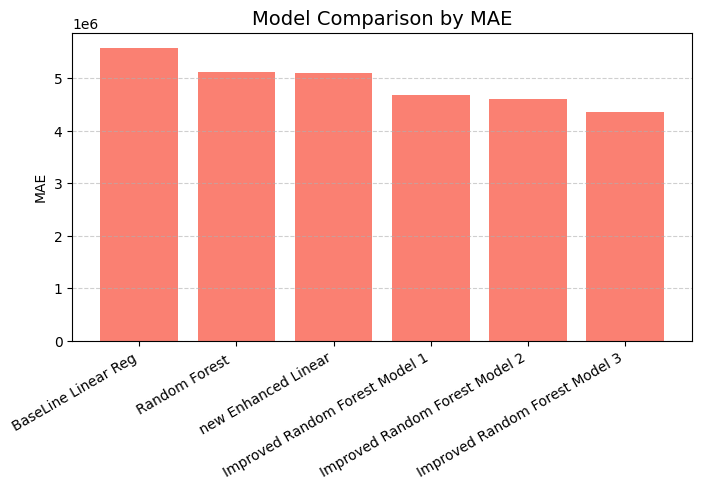

In [1174]:
# 🌳 IMPROVED RANDOM FOREST MODEL (LOG-TRANSFORMED TARGET)
# Goal: Reduce MAE & RMSE, Increase R²

# -------------------------------------------------------------
# 1️⃣ Import necessary libraries
# -------------------------------------------------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -------------------------------------------------------------
# 2️⃣ Define features (X) and target (y)
# -------------------------------------------------------------
X = train.drop(columns=['total_cost', 'id'])
y = train['total_cost']

# Apply log1p transform to stabilize variance and reduce skew
# log1p(x) = log(1 + x) handles zeros safely
y_log = np.log1p(y)

# -------------------------------------------------------------
# 3️⃣ Split data into training (85%) and validation (15%)
# -------------------------------------------------------------
X_train, X_val, y_train_log, y_val_log = train_test_split(
    X, y_log, test_size=0.15, random_state=42
)

# -------------------------------------------------------------
# 4️⃣ Initialize tuned Random Forest
# -------------------------------------------------------------
rf_model = RandomForestRegressor(
    n_estimators=800,        # more trees → better averaging
    max_depth=30,            # limit depth to avoid overfitting
    min_samples_split=5,     # require at least 5 samples to split a node
    min_samples_leaf=2,      # each leaf must have at least 2 samples
    max_features='sqrt',     # random subset of features per tree → better generalization
    random_state=42,
    n_jobs=-1
)

# -------------------------------------------------------------
# 5️⃣ Train the model on the log-transformed target
# -------------------------------------------------------------
rf_model.fit(X_train, y_train_log)

# -------------------------------------------------------------
# 6️⃣ Predict and inverse-transform predictions
# -------------------------------------------------------------
y_pred_log = rf_model.predict(X_val)

# Convert back to original TZS scale using expm1 (inverse of log1p)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_val_log)

# -------------------------------------------------------------
# 7️⃣ Evaluate model performance on original scale
# -------------------------------------------------------------
mae_imp3_rf = mean_absolute_error(y_true, y_pred)
rmse_imp3_rf = np.sqrt(mean_squared_error(y_true, y_pred))
r2_imp3_rf = r2_score(y_true, y_pred)

print("📊 Improved Random Forest (Log-Transformed Target):")
print(f"Mean Absolute Error (MAE): {mae_imp3_rf:,.2f} TZS")
print(f"Root Mean Squared Error (RMSE): {rmse_imp3_rf:,.2f} TZS")
print(f"R² Score: {r2_imp3_rf:.3f}")

# -------------------------------------------------------------
# 8️⃣ Log metrics (if you're using your metrics tracker)
# -------------------------------------------------------------
metrics.add("Improved Random Forest Model 3", mae_imp3_rf, rmse_imp3_rf, r2_imp3_rf)
metrics.show()
metrics.plot_mae()

# Evaluatiuon:

**Improved RF Model 3** has the lowest MAE, meaning it makes the smallest average prediction error.
→ It’s the best for precision (closest typical predictions).

**Improved RF Model 2** has the highest R² (0.44) and relatively low MAE.
→ It explains the most variance, so it’s slightly better overall in model fit.

**Enhanced Linear** has a low RMSE but a higher MAE and lower R² — meaning it sometimes does well but occasionally makes large errors.

🏆 **Best model overall: Improved Random Forest Model 2**

Why:

- It balances all three metrics best:

- Low MAE (only slightly higher than Model 3)

- Lowest RMSE among Random Forests

- Highest R², meaning it generalizes better.

- Likely more stable and consistent across data splits.

Runner-up:

Improved Random Forest Model 3 — has slightly lower MAE, but its R² (0.36) is much worse, indicating overfitting or less generalization.

# Predicting Test Data with best Model

In [1175]:
# 🌳 FINAL RANDOM FOREST MODEL (LOG-TRANSFORMED TARGET FOR SUBMISSION)
# Goal: Predict total_cost for test data using log-transformed Random Forest

# --------------------------------------------------------------
#  Import libraries
# --------------------------------------------------------------
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import os

# --------------------------------------------------------------
#  Prepare data (train & test already cleaned and encoded)
# --------------------------------------------------------------

# Remove total_cost from test (to avoid feature mismatch)
if 'total_cost' in test.columns:
    test = test.drop(columns=['total_cost'])

# Define features and target for training
X_train = train.drop(columns=['total_cost', 'id'])
y_train = train['total_cost']

# ✅ Apply log-transform to target to handle skewed cost distribution
y_train_log = np.log1p(y_train)

# Define test features (no total_cost)
X_test = test.drop(columns=['id'], errors='ignore')

# Ensure train and test have the same columns
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# --------------------------------------------------------------
#  Initialize tuned Random Forest
# --------------------------------------------------------------
rf_model = RandomForestRegressor(
    n_estimators=800,
    max_depth=30,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

# --------------------------------------------------------------
#  Train model on log-transformed target
# --------------------------------------------------------------
rf_model.fit(X_train, y_train_log)

# --------------------------------------------------------------
#  Predict on test data (still in log scale)
# --------------------------------------------------------------
y_pred_log = rf_model.predict(X_test)

# Inverse transform to original TZS scale
y_pred_test = np.expm1(y_pred_log)

# --------------------------------------------------------------
#  Load sample submission and insert predictions
# --------------------------------------------------------------
sample_submission_path = os.path.join('data', 'SampleSubmission.csv')
submission = pd.read_csv(sample_submission_path)

# Normalize column names (case-insensitive merge safety)
submission.columns = submission.columns.str.lower()
test.columns = test.columns.str.lower()

# Ensure total_cost column exists
if 'total_cost' not in submission.columns:
    submission['total_cost'] = np.nan

# Match IDs and assign predictions
if 'id' in submission.columns and 'id' in test.columns:
    submission = submission[['id']].copy()
    submission['total_cost'] = y_pred_test
else:
    submission['total_cost'] = y_pred_test

# --------------------------------------------------------------
#  Save final submission file
# --------------------------------------------------------------
output_path = os.path.join('data', 'SampleSubmission.csv')
submission.to_csv(output_path, index=False)

print("✅ Log-Transformed Random Forest Predictions saved to:")
print(output_path)
print(submission.head())

✅ Log-Transformed Random Forest Predictions saved to:
data\SampleSubmission.csv
          id    total_cost
0     tour_1 11,472,449.59
1   tour_100  4,326,456.60
2  tour_1001  6,246,269.56
3  tour_1006  1,441,500.46
4  tour_1009 19,632,001.81


In [1177]:

# 📊 EVALUATE RANDOM FOREST (LOG-TRANSFORMED TARGET)

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Split into train/validation
X = train.drop(columns=['total_cost', 'id'])
y = train['total_cost']

# Apply log-transform to target
y_log = np.log1p(y)

X_train, X_val, y_train_log, y_val_log = train_test_split(
    X, y_log, test_size=0.15, random_state=42
)

# Train the same Random Forest
rf_eval = RandomForestRegressor(
    n_estimators=800,
    max_depth=30,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

rf_eval.fit(X_train, y_train_log)

# Predict (log scale)
y_pred_log = rf_eval.predict(X_val)

# Convert both prediction and validation target back to original scale
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_val_log)

# Compute metrics
mae_erf = mean_absolute_error(y_true, y_pred)
rmse_erf = np.sqrt(mean_squared_error(y_true, y_pred))
r2_erf = r2_score(y_true, y_pred)

print("📊 Random Forest (Log-Transformed Target) Evaluation:")
print(f"Mean Absolute Error (MAE): {mae_erf:,.2f} TZS")
print(f"Root Mean Squared Error (RMSE): {rmse_erf:,.2f} TZS")
print(f"R² Score: {r2_erf:.3f}")

📊 Random Forest (Log-Transformed Target) Evaluation:
Mean Absolute Error (MAE): 4,362,311.43 TZS
Root Mean Squared Error (RMSE): 8,999,912.50 TZS
R² Score: 0.356
